# Heart Disease Prediction
Author: Seán Coffey
Date: September 2025


## Objectives
Purpose: Build and evaluate models to predict heart disease from clinical features.
Key outcomes: a) clean dataset, b) strong baseline, c) validated model, d) interpretable insights.

## Project Setup


### Reproducibility


In [1]:
import os
import sys
import random
import numpy as np
import pandas as pd
import kagglehub   # need this to download dataset
import math
import statsmodels.api as sm

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import seaborn as sns
%matplotlib inline

from sklearn.base import clone
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.calibration import CalibratedClassifierCV
from sklearn.inspection import permutation_importance
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve,
    RocCurveDisplay, PrecisionRecallDisplay,
    mean_squared_error, mean_absolute_error, r2_score,
    f1_score, accuracy_score, precision_score, recall_score
)

from pathlib import Path
from tqdm.autonotebook import tqdm as notebook_tqdm

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# Plotting defaults
sns.set_theme(context="notebook", style="darkgrid", palette="deep")
plt.rcParams.update({
    "figure.figsize": (8, 5),
    "figure.dpi": 120,
    "axes.titlesize": 14,
    "axes.labelsize": 12
})

print("Python:", sys.version.split()[0])
print("Pandas:", pd.__version__)

/Users/seancoffey/PycharmProjects/ML_course/.venv-3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Python: 3.11.13
Pandas: 2.3.2


### Data Access

In [2]:
# Download latest version of dataset
path = kagglehub.dataset_download("redwankarimsony/heart-disease-data")
print("Path to dataset files:", path)
p = Path(path)

files = [f.name for f in p.iterdir() if f.is_file()]
print("Files in folder:")
for name in files:
    print("-", name)

csv_files = sorted(p.rglob("*.csv"))  # search recursively
if not csv_files:
    raise FileNotFoundError(f"No CSV files found under {p}")
heart_data = pd.read_csv(csv_files[0])
print("Loaded:", csv_files[0].name, heart_data.shape)
heart_data.head()

Path to dataset files: /Users/seancoffey/.cache/kagglehub/datasets/redwankarimsony/heart-disease-data/versions/6
Files in folder:
- heart_disease_uci.csv
Loaded: heart_disease_uci.csv (920, 16)


,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


### About the Dataset

**Kaggle web-page:** https://www.kaggle.com/datasets/redwankarimsony/heart-disease-data/data

#### Summary

This is a multivariate type of dataset which means providing or involving a variety of separate mathematical or statistical variables, multivariate numerical data analysis. It is composed of 14 attributes which are age, sex, chest pain type, resting blood pressure, serum cholesterol, fasting blood sugar, resting electrocardiographic results, maximum heart rate achieved, exercise-induced angina, oldpeak — ST depression induced by exercise relative to rest, the slope of the peak exercise ST segment, number of major vessels and Thalassemia. This database includes 76 attributes, but all published studies relate to the use of a subset of 14 of them. The Cleveland database is the only one used by ML researchers to date. One of the major tasks on this dataset is to predict based on the given attributes of a patient that whether that particular person has heart disease or not and other is the experimental task to diagnose and find out various insights from this dataset which could help in understanding the problem more.

#### Features

- id (Unique id for each patient)
- age (Age of the patient in years) - range: 28 to 77
- sex (Male/Female)
- dataset (place of study) ['Cleveland' 'Hungary' 'Switzerland' 'VA Long Beach']
- cp chest pain type ([typical angina, atypical angina, non-anginal, asymptomatic])
- trestbps resting blood pressure (resting blood pressure (in mm Hg on admission to the hospital))
- chol (serum cholesterol in mg/dl) - range: 0(missing value?) to 603
- fbs (if fasting blood sugar > 120 mg/dl) - Boolean (1 = true; 0 = false)
- restecg (resting electrocardiographic results), Values: [normal, stt abnormality, lv hypertrophy]
- thalach: maximum heart rate achieved - range: 60 to 202
- exang: exercise-induced angina (True/ False)
- oldpeak: ST depression induced by exercise relative to rest, it indicates an abnormality in heart's electrical activity and is characterized by a downward deflection of ST segment (in ECG results). Range: -2.6 to 6.2
- slope: the slope of the peak exercise ST segment, Values: [upsloping, flat, downsloping]
- ca: number of major vessels (0-3) colored by fluoroscopy
- thal: [normal; fixed defect; reversible defect]
- num: the predicted attribute, Values: [0,1,2,3,4] - meaning the extent of heart disease [none, mild, moderate, severe, critical]

#### The Target Variable
The target variable 'num'[0,1,2,3,4] can be considered to be categorical with five classes [none, mild, moderate, severe, critical]. But these classes are clearly ordinal, severity increases with increasing values of num.
There are some important decisions to be made when constructing a predictive model:
1. Use the variable as a multi-class classifier, although this could cause complications in data-preprocessing (construct one or others versions) or limit our choice of model (those that support multi-class classification).
2. Change to a binary classification problem with the target variable 'num_binary' as the class label. (Potentially 0 = False and 1,2,3,4 = True)
4. Use 'num' as a numerical value and solve as a regression problem.

Domain knowledge would help here, (e.g. is a binary predictor useful? would it be better to include 'mild' in False?). For the purposes of this project, let's create a 'num_bin' as above and compare models for 'multi-class', 'bin' and 'regression'.

This will also require that some thought goes into the choice of metric to evaluate accuracy and predictive power.

In [3]:
display(heart_data.info())
display(heart_data.describe(include="all"))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB


None

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
count,920.000000,920.000000,920,920,920,861.000000,890.000000,830,918,865.000000,865,858.000000,611,309.000000,434,920.000000
unique,NaN,NaN,2,4,4,NaN,NaN,2,3,NaN,2,NaN,3,NaN,3,NaN
top,NaN,NaN,Male,Cleveland,asymptomatic,NaN,NaN,False,normal,NaN,False,NaN,flat,NaN,normal,NaN
freq,NaN,NaN,726,304,496,NaN,NaN,692,551,NaN,528,NaN,345,NaN,196,NaN
mean,460.500000,53.510870,NaN,NaN,NaN,132.132404,199.130337,NaN,NaN,137.545665,NaN,0.878788,NaN,0.676375,NaN,0.995652
std,265.725422,9.424685,NaN,NaN,NaN,19.066070,110.780810,NaN,NaN,25.926276,NaN,1.091226,NaN,0.935653,NaN,1.142693
min,1.000000,28.000000,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,60.000000,NaN,-2.600000,NaN,0.000000,NaN,0.000000
25%,230.750000,47.000000,NaN,NaN,NaN,120.000000,175.000000,NaN,NaN,120.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000
50%,460.500000,54.000000,NaN,NaN,NaN,130.000000,223.000000,NaN,NaN,140.000000,NaN,0.500000,NaN,0.000000,NaN,1.000000
75%,690.250000,60.000000,NaN,NaN,NaN,140.000000,268.000000,NaN,NaN,157.000000,NaN,1.500000,NaN,1.000000,NaN,2.000000


##  Exploratory Data Analysis (EDA)

In [4]:
# Check data for categorical columns
catgoricals = ['sex','dataset','cp','fbs','restecg','exang','slope','thal','num']
for col in catgoricals:
    print(f'{col}: {heart_data[col].unique()}')
#heart_data[catgoricals] = heart_data[catgoricals].astype('category')
print(f"\nFor {heart_data.shape[0]} rows we have {heart_data['id'].nunique()} patient IDs.\n") # check num rows = num patients

target_col = "num"  # adjust to your dataset
ratios_pct_str = (heart_data[target_col].value_counts(normalize=True).mul(100).round(1).astype(str) + "%")
print(f'The class ratios given target variable {ratios_pct_str}')

sex: ['Male' 'Female']
dataset: ['Cleveland' 'Hungary' 'Switzerland' 'VA Long Beach']
cp: ['typical angina' 'asymptomatic' 'non-anginal' 'atypical angina']
fbs: [True False nan]
restecg: ['lv hypertrophy' 'normal' 'st-t abnormality' nan]
exang: [False True nan]
slope: ['downsloping' 'flat' 'upsloping' nan]
thal: ['fixed defect' 'normal' 'reversable defect' nan]
num: [0 2 1 3 4]

For 920 rows we have 920 patient IDs.

The class ratios given target variable num
0    44.7%
1    28.8%
2    11.8%
3    11.6%
4     3.0%
Name: proportion, dtype: object


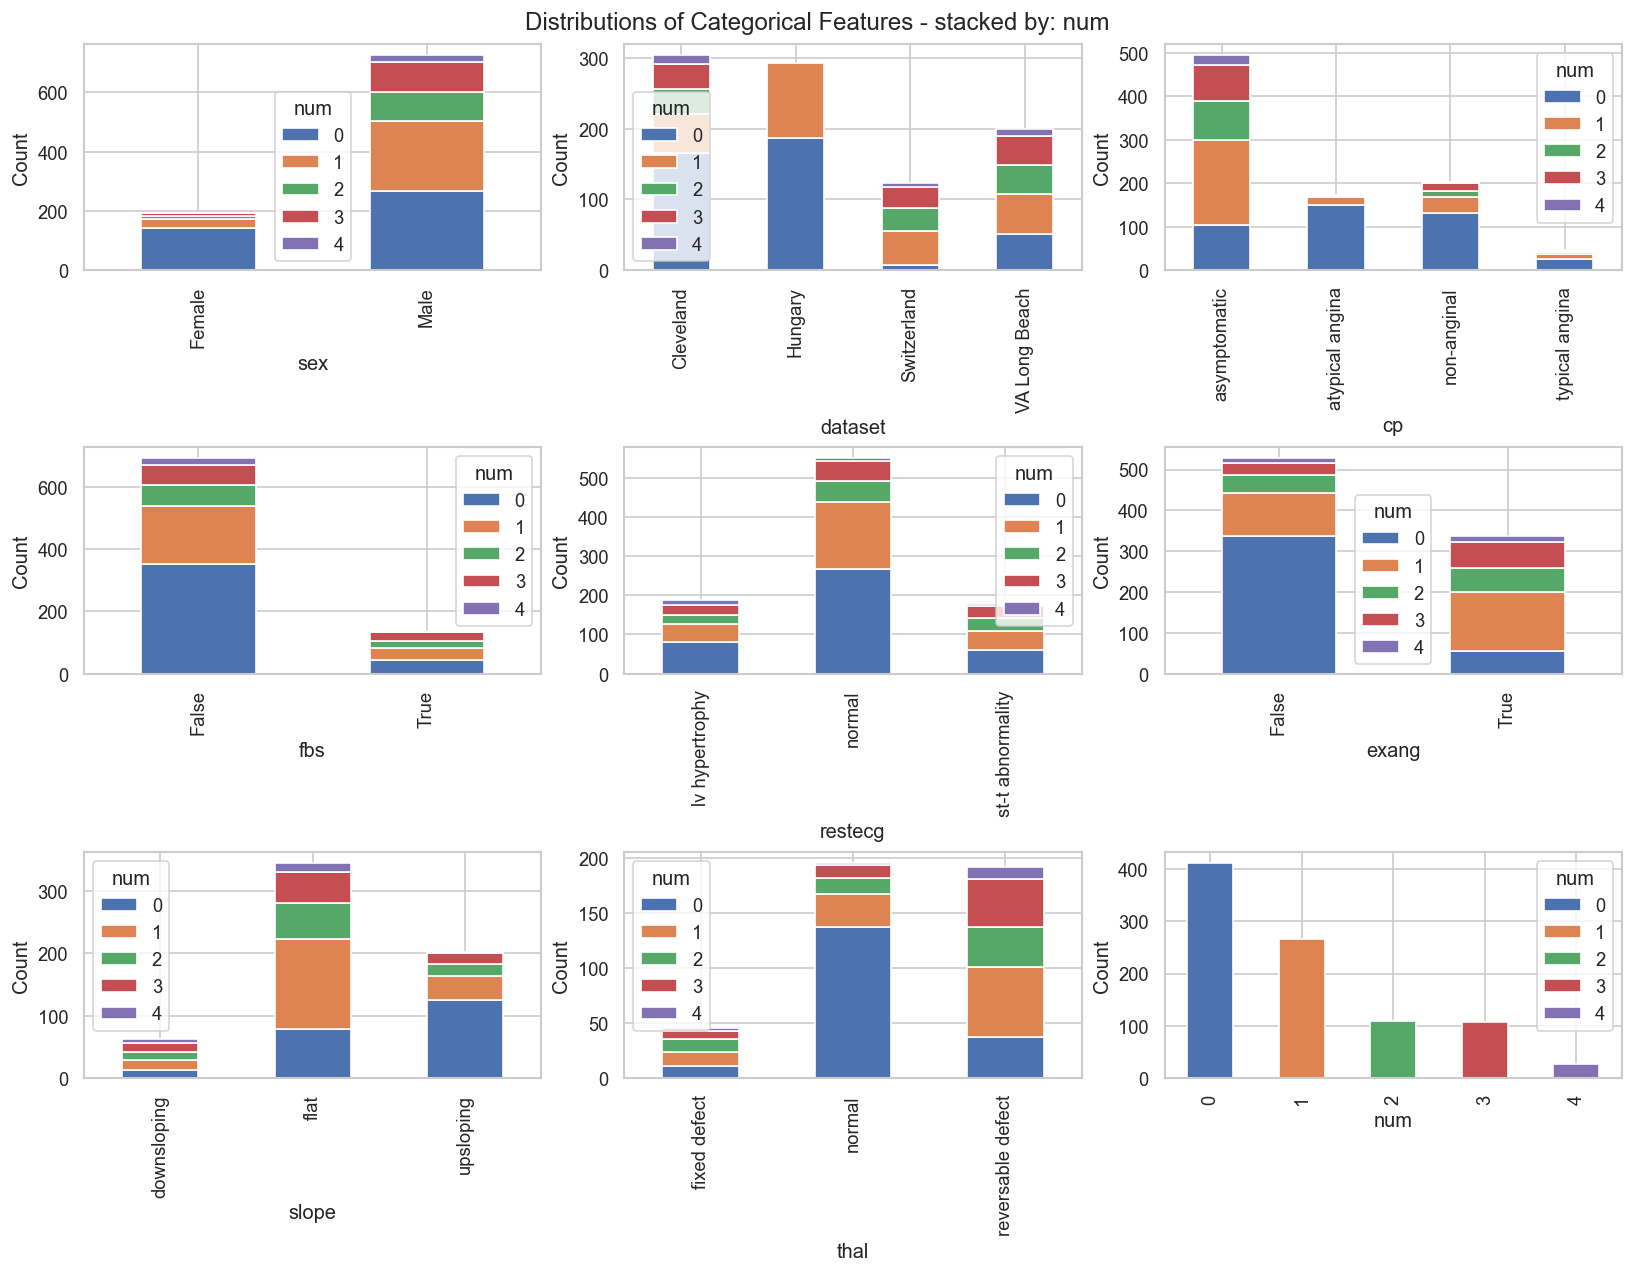


 -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- 



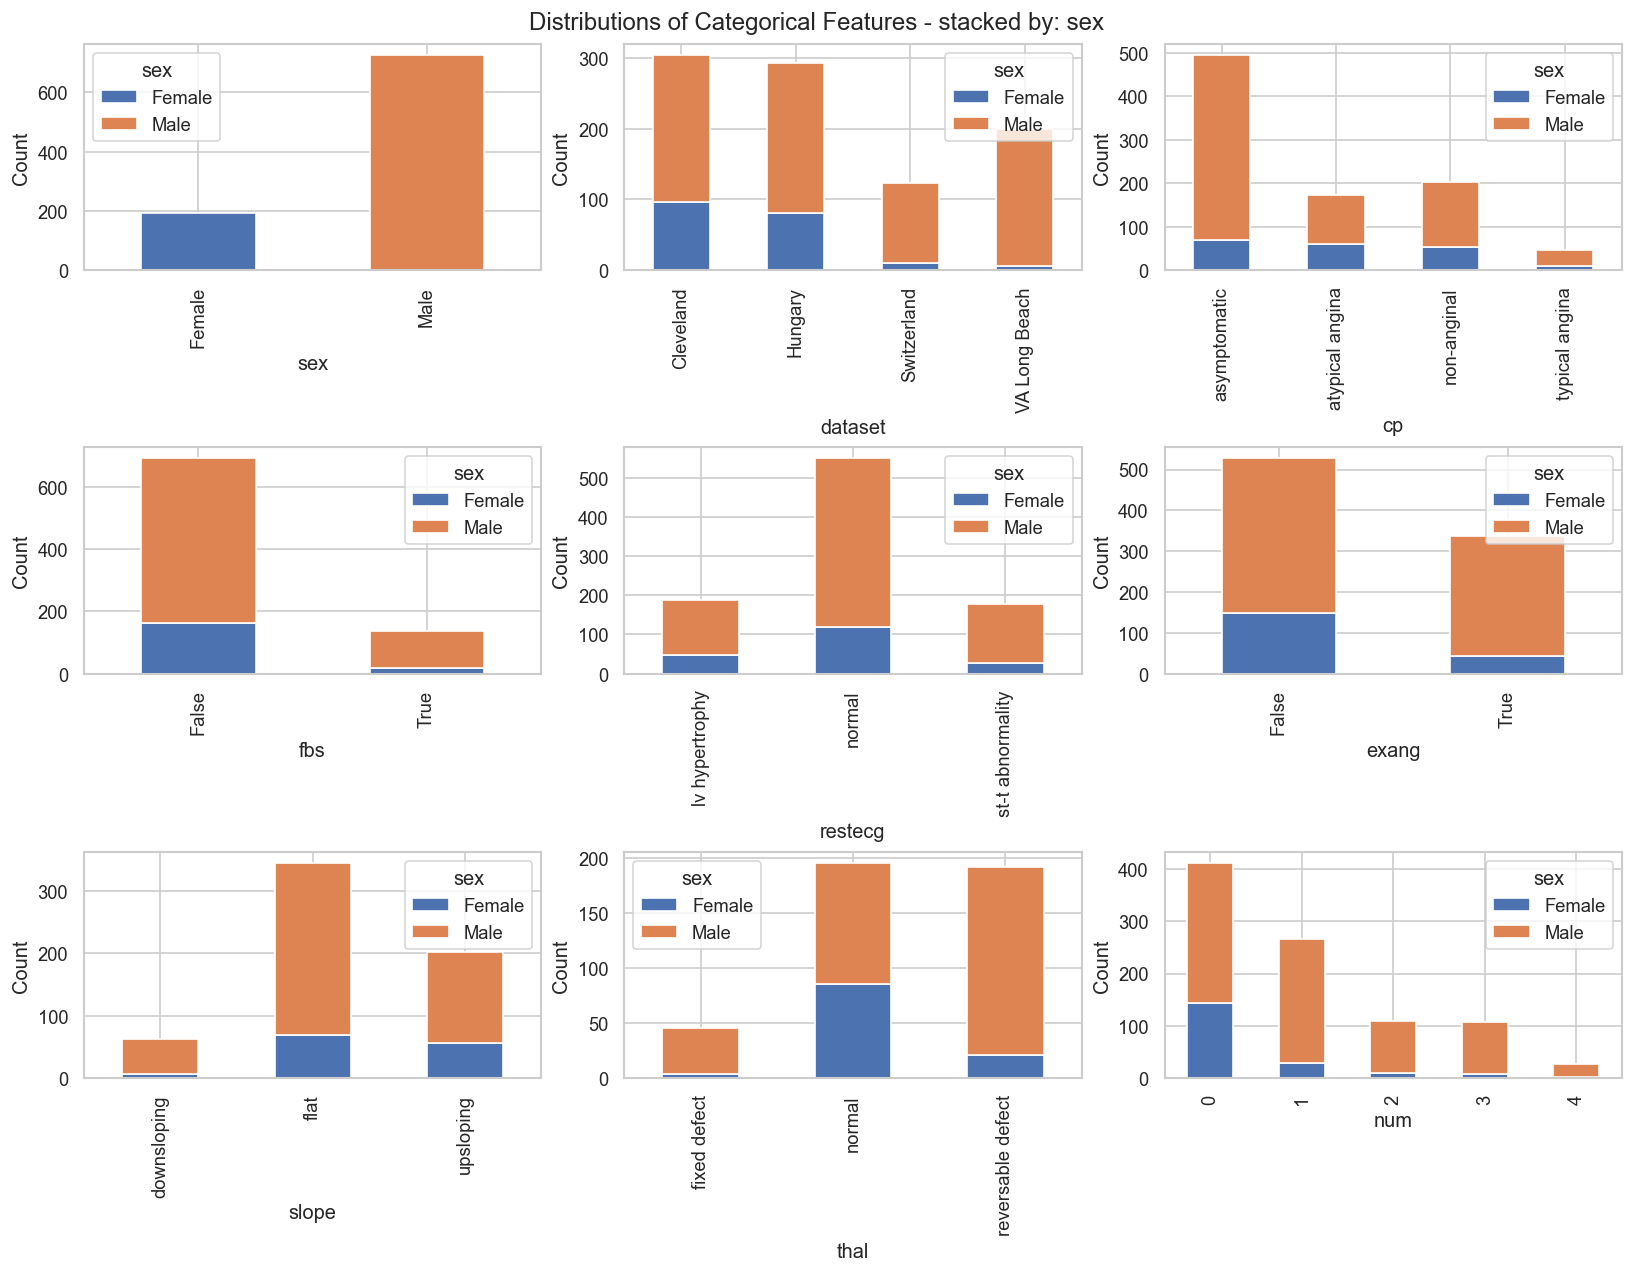


 -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- 



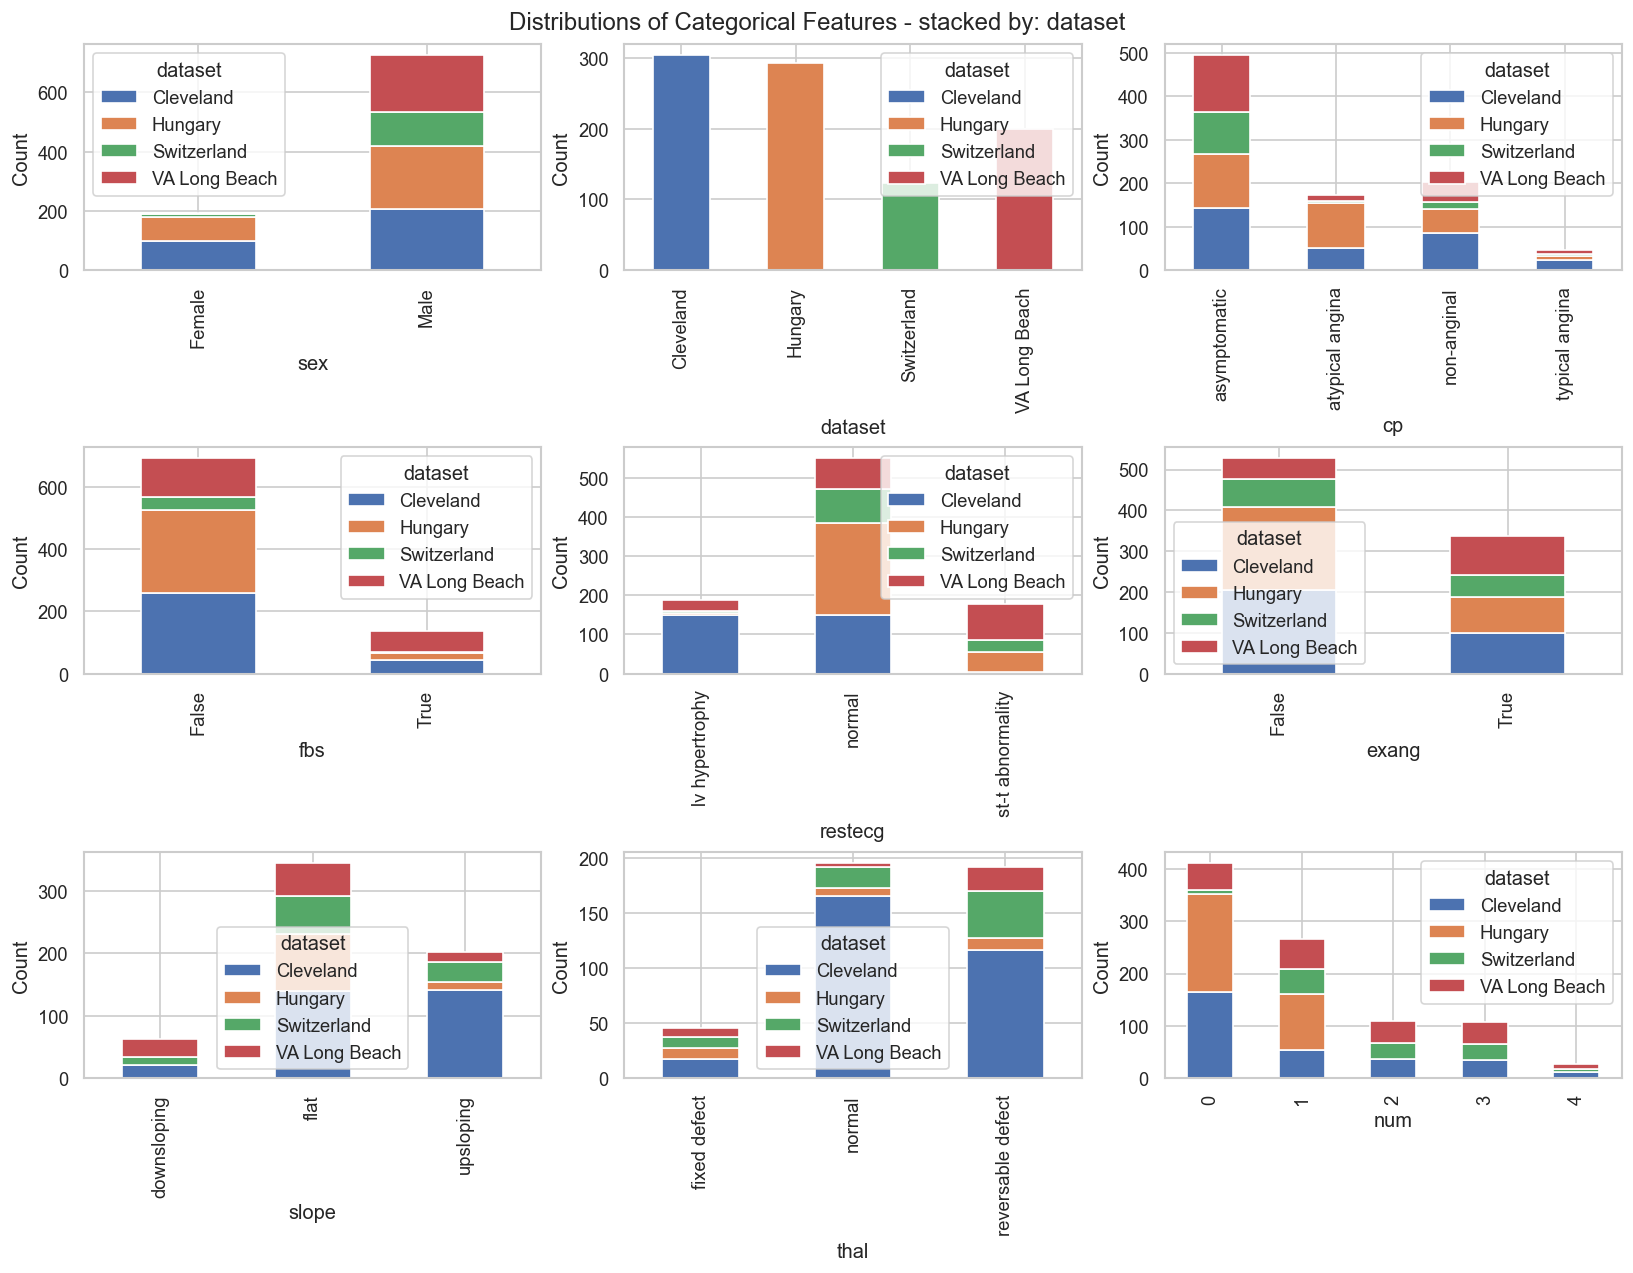


 -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- 



In [5]:
# Explore categoricals
n = len(catgoricals)
n_cols = 3
n_rows = math.ceil(n / n_cols)

def section_split(width=200, char="-"):
    print("\n", char * width, "\n")

def stacked_count_plot(stack):
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4.5, n_rows * 3.5), constrained_layout=True)
    axes = np.array(axes).reshape(-1)  # flatten in case of single row/col

    for i, col in enumerate(catgoricals):
        ax = axes[i]
        pd.crosstab(heart_data[col], heart_data[stack]).plot(kind="bar", stacked=True, ax=ax)
        ax.set_xlabel(col)
        ax.set_ylabel("Count")

    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    fig.suptitle("Distributions of Categorical Features - stacked by: " + stack)
    plt.show()

# Stacking by target variable - a visual indication of which categorical features are most important
stacked_count_plot("num")
section_split()

# Stacking by sex - is the data very different for male/female?
stacked_count_plot('sex')
section_split()

# Stacking by dataset - is the data different for different locations?
stacked_count_plot('dataset')
section_split()


### Categorical Data Observations
1. The ratio of male to female in the data is approx 3:1 overall and there is almost no female data in the Switzerland or VA Long Beach datasets
2. The data by location(dataset) is very differently distributed. Hungary has no serious cases of serious heart disease (or were they using a more limited binary classification?)
3. Resting ECG (restecg) seems to be (based on visual inspection) a strong indicator of likelihood of heart disease.
4. As does exercised induced angina (exang).


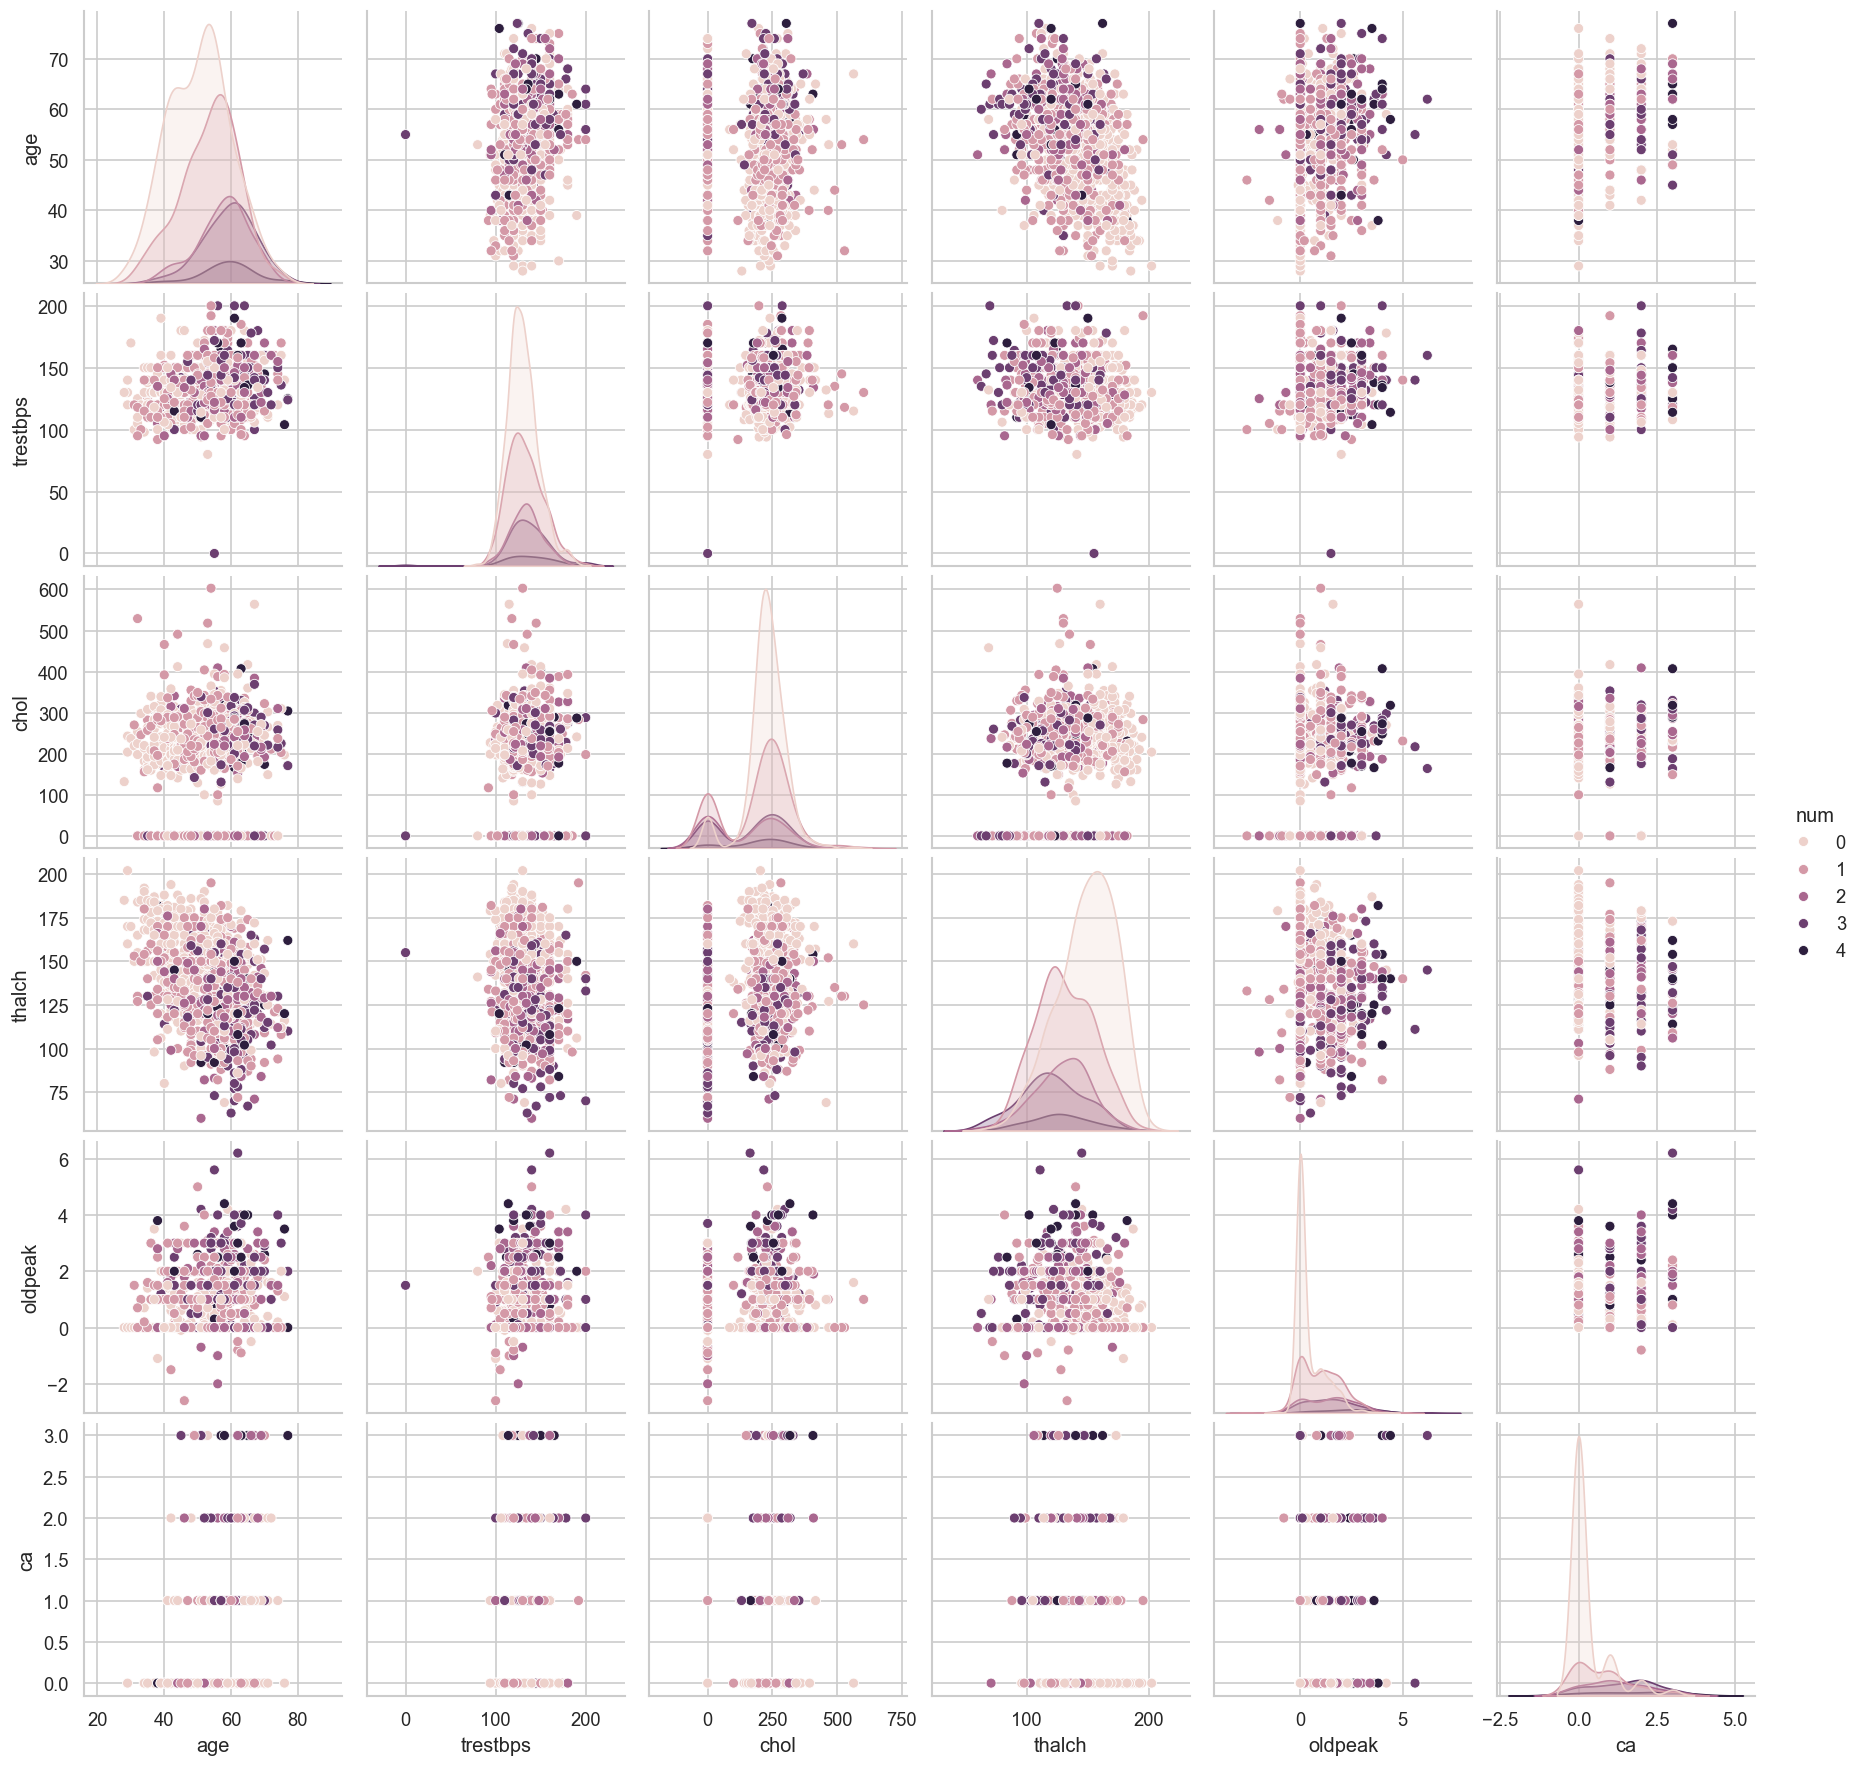

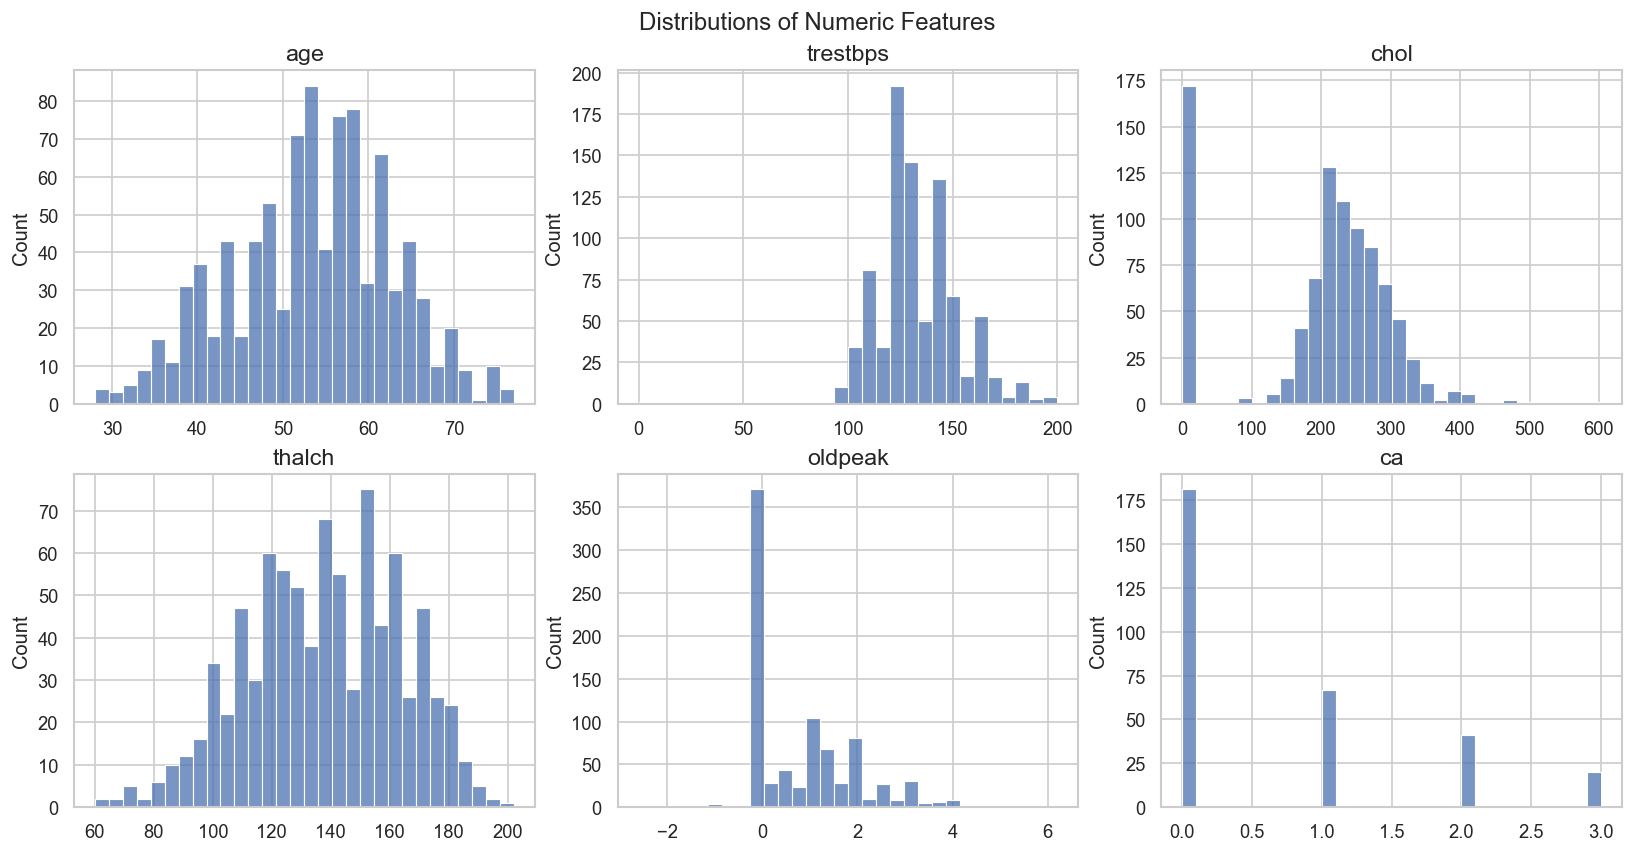

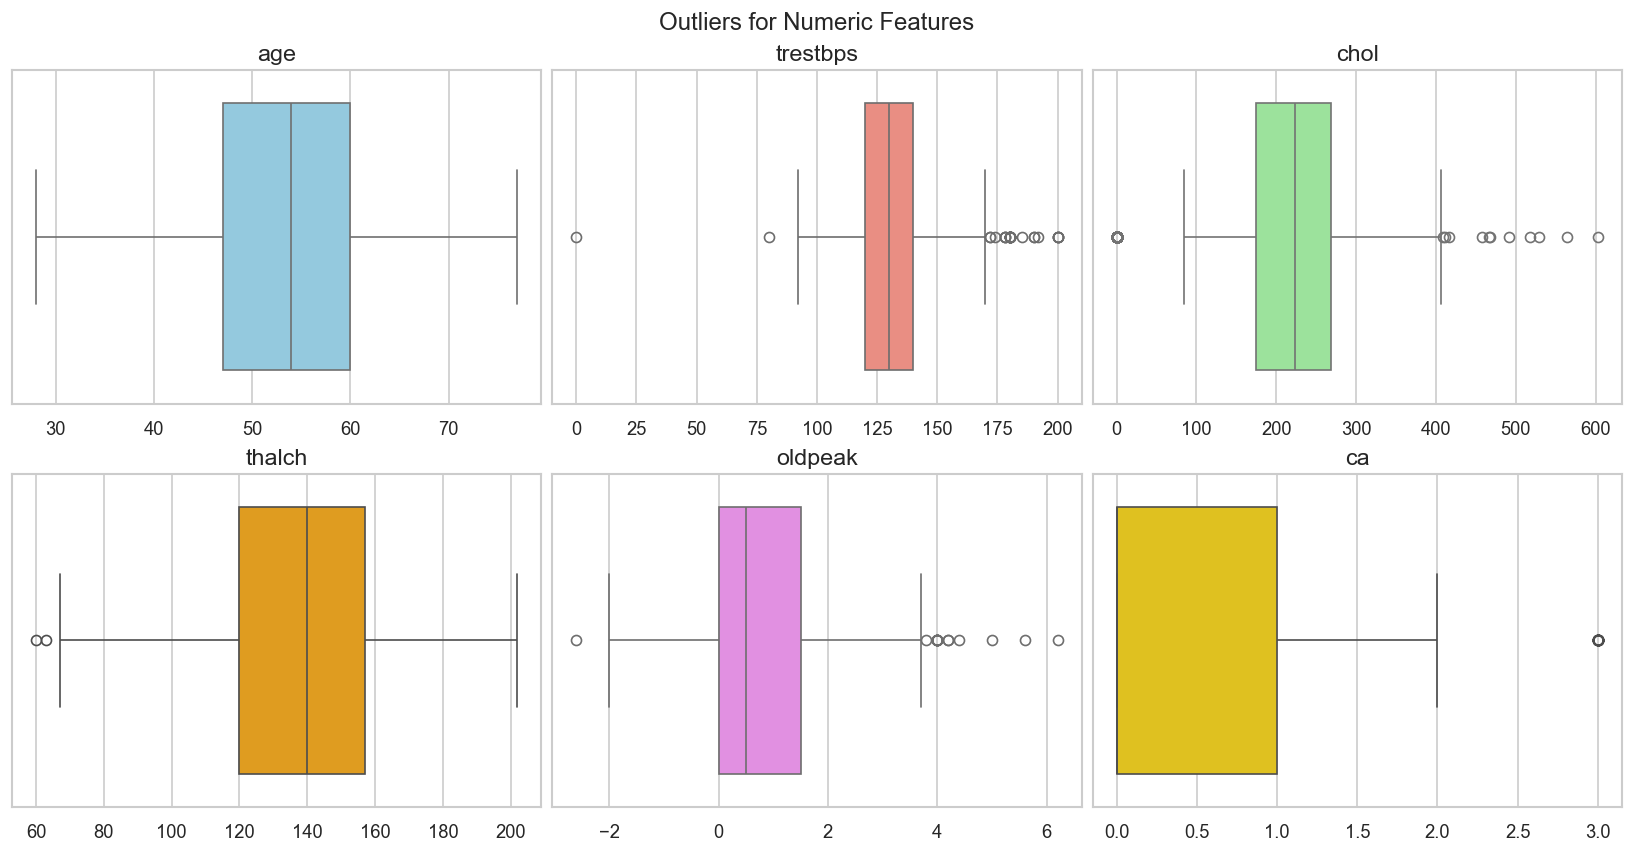

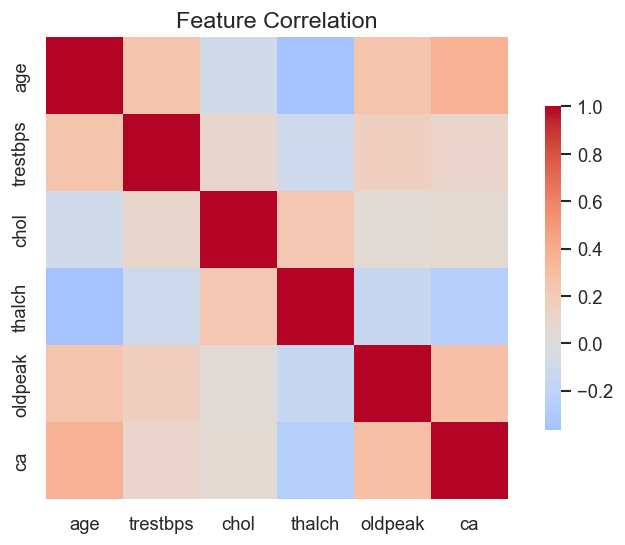

In [6]:
# Explore numeric columns
numeric_cols = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']
n = len(numeric_cols)
n_cols = 3
n_rows = math.ceil(n / n_cols)

## Let's start with a simple pairplot
sns.pairplot(heart_data, hue=target_col, vars=numeric_cols, diag_kind="kde")
plt.show()

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4.5, n_rows * 3.5), constrained_layout=True)
axes = np.array(axes).reshape(-1)  # flatten in case of single row/col

# Plot distributions for numeric columns - a little more clarity on the distributions
for i, col in enumerate(numeric_cols):
    ax = axes[i]
    sns.histplot(heart_data[col].dropna(), bins=30, kde=False, ax=ax)
    ax.set_title(col)
    ax.set_xlabel("")
    ax.set_ylabel("Count")

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

fig.suptitle("Distributions of Numeric Features")
plt.show()

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4.5, n_rows * 3.5), constrained_layout=True)
axes = np.array(axes).reshape(-1)  # flatten in case of single row/col

# Show outliers for numeric columns
colors = ["skyblue", "salmon", "lightgreen", "orange", "violet", "gold"]
for i, col in enumerate(numeric_cols):
    ax = axes[i]
    sns.boxplot(x = heart_data[col], ax=ax, color=colors[i])
    ax.set_title(col)
    ax.set_xlabel("")

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

fig.suptitle("Outliers for Numeric Features")
plt.show()

# Correlation heatmap
corr = heart_data[numeric_cols].corr(numeric_only=True)
sns.heatmap(corr, cmap="coolwarm", center=0, square=True, cbar_kws={"shrink": 0.7})
plt.title("Feature Correlation")
plt.show()


### Numerical Feature Observations
1. There are no strong correlations between numerical features to concern us.
2. The age distribution is a little skewed to the right, and older patients tend to show greater likelihood of more serious conditions.
3. Distributions look ok, but we should worry about the meaning of zero values for cholesterol and oldpeak
4. We may need to remove outliers for trestbps, chol, thalch, oldpeak and ca. (need to check further first)

id            0.0%
age           0.0%
sex           0.0%
dataset       0.0%
cp            0.0%
trestbps     6.41%
chol         3.26%
fbs          9.78%
restecg      0.22%
thalch       5.98%
exang        5.98%
oldpeak      6.74%
slope       33.59%
ca          66.41%
thal        52.83%
num           0.0%
dtype: object


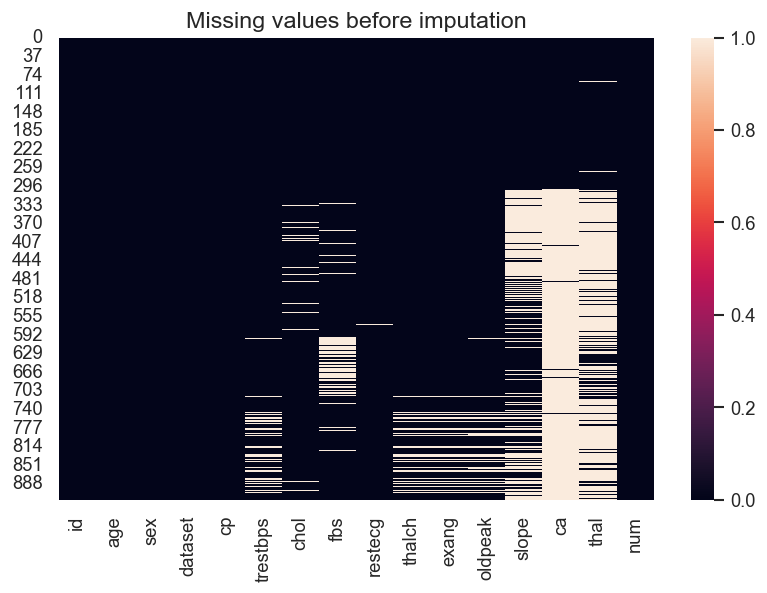

Rows per dataset:
 dataset
Cleveland        304
Hungary          293
VA Long Beach    200
Switzerland      123
Name: count, dtype: int64 

                id  age  sex   cp  trestbps  chol    fbs  restecg  thalch  \
dataset                                                                     
Cleveland      0.0  0.0  0.0  0.0      0.00  0.00   0.00     0.00    0.00   
Hungary        0.0  0.0  0.0  0.0      0.34  7.85   2.73     0.34    0.34   
Switzerland    0.0  0.0  0.0  0.0      1.63  0.00  60.98     0.81    0.81   
VA Long Beach  0.0  0.0  0.0  0.0     28.00  3.50   3.50     0.00   26.50   

               exang  oldpeak  slope     ca   thal  num  
dataset                                                  
Cleveland       0.00     0.00   0.33   1.64   0.99  0.0  
Hungary         0.34     0.00  64.51  98.98  90.44  0.0  
Switzerland     0.81     4.88  13.82  95.93  42.28  0.0  
VA Long Beach  26.50    28.00  51.00  99.00  83.00  0.0  


In [7]:
# Explore Missing Values
print(round(heart_data.isnull().sum() * 100 / len(heart_data), 2).astype(str) + '%')
sns.heatmap(heart_data.isnull())
plt.title('Missing values before imputation')
plt.show()

# do missing values vary by location (dataset)?
group_col = "dataset"
value_cols = heart_data.columns.drop(group_col)

row_counts = heart_data[group_col].value_counts(dropna=False)
print("Rows per dataset:\n", row_counts, "\n")

null_pct_by_dataset = (
    heart_data
    .groupby(group_col, dropna=False)[value_cols]
    .apply(lambda g: g.isna().mean().mul(100))
    .round(2)
)

print(null_pct_by_dataset)


### Missing Value Observations
1. ca, slope and thal are to a large extent missing from all locations except Cleveland.
2. In fact the only location that doesn't have some form of missing data is Cleveland.
3. VA Long Beach has significant missing data in all features that are likely to have predictive value.

The extent of the missing data suggests that blanket use of imputation may not be a good idea:
1. Deep domain knowledge is needed to know whether imputing a mean, a mode or using KNN is really the right thing to do.
2. Any predictive model (the objective of this project) would have limited credibility with this number of manufactured features.

There are two possible ways forward
1. Produce a model limited to the Cleveland dataset, which still has n = 304
2. Remove the features with missing data (slope, ca and thal) and train a model on the remaining features. For this option, we would still need to remove VA Long Beach if we want any features beyond chol and ecg to play with, so n = 720.

At this stage, I am uncertain which option I prefer. It is uncomfortable to give-up 2/3 of the data. But equally, it seems overly limiting to give up 4 of the 12 predictive features. It is already becoming clear how important domain knowledge is to effective modelling. If the objective was to produce a model usable in the field, I would first find a way to get some domain help with these data issues. However, for this project I am focusing on the modelling aspects and my own learning.

One of the reasons that I selected this dataset to work with is that there are a number of solutions published on Kaggle that are based on it. This means that I can compare my approach with how others have done it and hopefully learn from such comparisons. From the first few I have examined:
- 3 made heavy use of SimpleImputer based imputation to replace missing categoricals with the most frequent value.
- I couldn't find one that took a similar approach to the one I am proposing
- Although there is extensive EDA exhibited in the samples I viewed, I couldn't find one that explored the missing data by location. For me, this is the explanation for why others chose Imputation to resolve the missing data.

Decision: I am comfortable with my decision making, I will work with Cleveland first and then try to judge how it may or may not be extendable to include the other locations and if it is worth modelling with fewer predictors. This may mean revisiting the pre-processing steps for the broader dataset.


## Preprocessing
- Add a binary target column (1 = heart disease, 0 = no heart disease)
- Basic imputation/cleanup
- Train/test split

Note: I will handle scaling and one-hot encoding as needed inside a pipeline with ColumnTransformer.

In [8]:
# Start by adding a binary target column
heart_data['num_bin'] = heart_data[target_col].map({0: False, 1: True, 2: True, 3: True, 4: True})
print(heart_data['num_bin'].value_counts())
# Variable used to select positive-class for binary classification.
pos_idx = 1
# Create two possible splits of the data according to missing value observations
# cleveland_heart with only one location but maintaining all the features
cleveland_heart = heart_data[heart_data['dataset'] == 'Cleveland'].copy()
# in case we need it later the simple_heart extended datasets with removed features
simple_heart = heart_data[heart_data['dataset'] != 'VA Long Beach'].copy()
simple_heart.drop(['slope','ca','thal'], axis=1, inplace=True)

num_bin
True     509
False    411
Name: count, dtype: int64


In [9]:
# Look at the missing values again for Cleveland
cols_with_missing = cleveland_heart.columns[cleveland_heart.isna().any()].tolist()
subset = cleveland_heart.loc[:, cols_with_missing]
rows_with_counts = (
    subset.assign(n_missing=subset.isna().sum(axis=1))
          .query("n_missing > 0")
          .sort_values("n_missing", ascending=False)
)
print(rows_with_counts)

         slope   ca               thal  n_missing
303        NaN  NaN                NaN          3
87   upsloping  0.0                NaN          1
166  upsloping  NaN             normal          1
192       flat  NaN  reversable defect          1
266       flat  0.0                NaN          1
287       flat  NaN  reversable defect          1
302  upsloping  NaN             normal          1


### Missing Values and Outliers
For the Cleveland dataset:
- Remove row 303 which has 3 missing values
- The other 6 rows with missing values have one missing value, all of them are categorical (ca is ordinal), so using a simple imputer is a reasonable choice.
- Without domain knowledge, it is probably best to keep the outliers, I have no idea if they are plausible or not. None of them seem to have a data-quality based explanation (e.g. 0 or infinity as entries)

In [10]:
# Cleveland Cleaning
# Drop row 303 which has 3 missing values
if 303 in cleveland_heart.index:
    cleveland_heart = cleveland_heart.drop(index=303)
# impute missing values for slope, ca and thal using most frequent value
cat_imp = SimpleImputer(strategy="most_frequent")
imputed_cols = pd.DataFrame(
    cat_imp.fit_transform(cleveland_heart[['thal', 'ca']]),
    columns=['thal', 'ca'],
    index=cleveland_heart.index
)
cleveland_clean = cleveland_heart.copy()
cleveland_clean[['thal', 'ca']] = imputed_cols
# check cleaning removed all missing values
assert cleveland_clean.isnull().sum().sum() == 0, "Missing values remain after imputation"


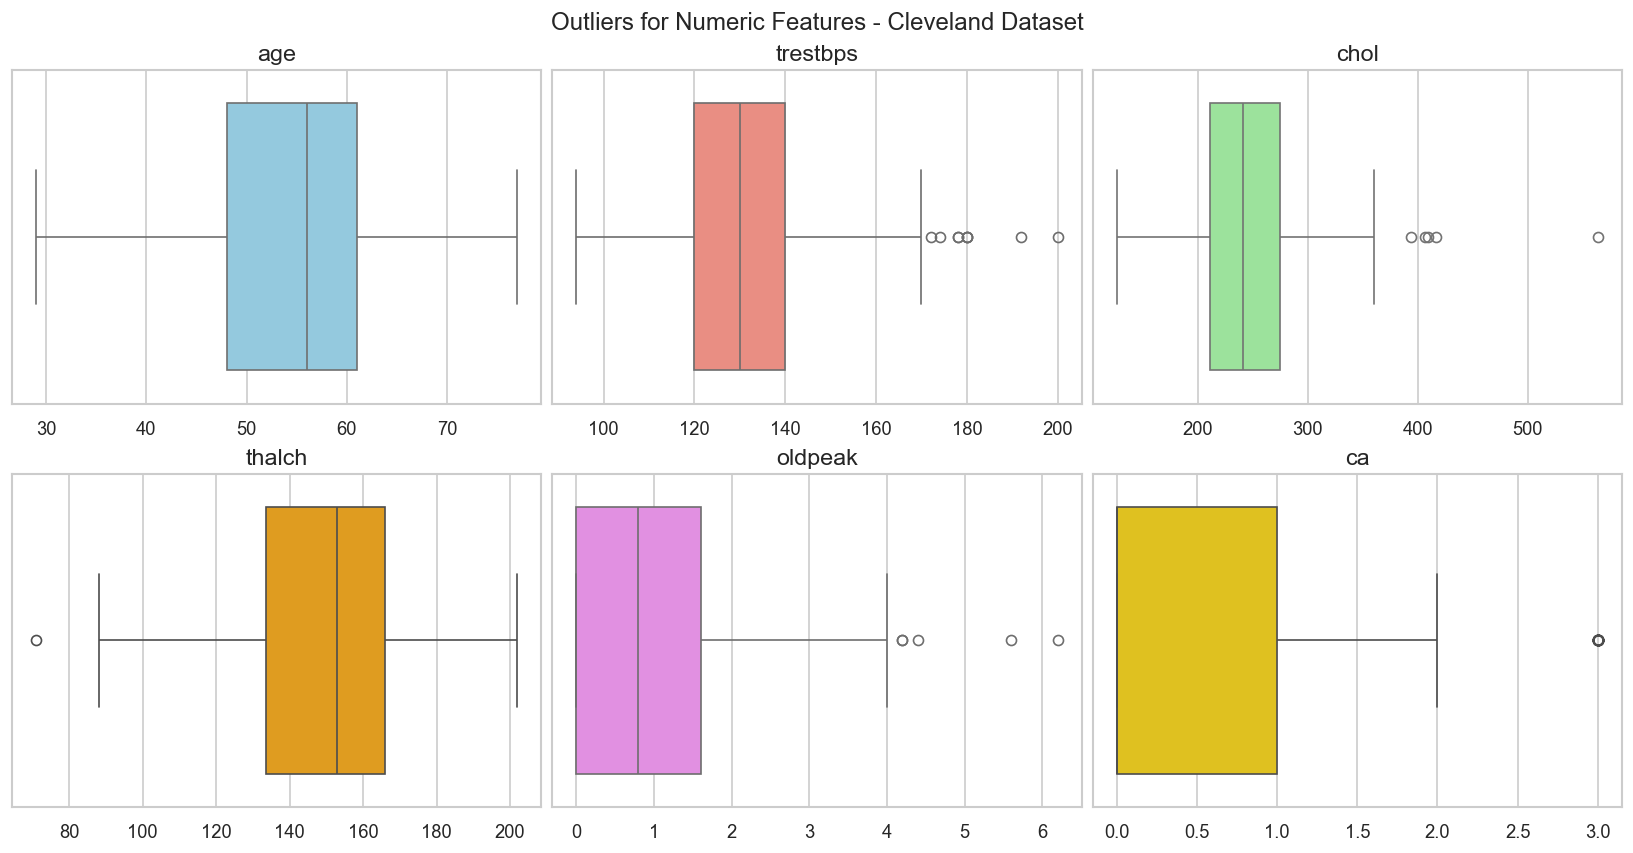

In [11]:
# Check outliers
# Show outliers for numeric columns
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4.5, n_rows * 3.5), constrained_layout=True)
axes = np.array(axes).reshape(-1)  # flatten in case of single row/col
for i, col in enumerate(numeric_cols):
    ax = axes[i]
    sns.boxplot(x = cleveland_clean[col], ax=ax, color=colors[i])
    ax.set_title(col)
    ax.set_xlabel("")

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

fig.suptitle("Outliers for Numeric Features - Cleveland Dataset")
plt.show()

In [12]:
df_clean = cleveland_clean.copy()   # I want to try to keep it easy to replace cleveland_clean with simple_heart later
df_clean = df_clean.dropna(axis=0)  # just in case we missed any missing values
target_cols = ['num', 'num_bin']    # remembering we want to end up with a multi-class target, a binary target and a regression problem.

X = df_clean.drop(columns=target_cols +['id','dataset'])
y = df_clean[target_cols]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size = 0.20,
    stratify = y['num'],
    random_state = SEED
)
# create two versions of y, one for binary classification and one for regression/multi-class
y_bin_train = y_train['num_bin']
y_bin_test = y_test['num_bin']
y_reg_train = y_train['num']
y_reg_test = y_test['num']

# Print shapes to check that we have the right data for the models
X_train.shape, X_test.shape, y_bin_train.shape, y_bin_test.shape, y_reg_train.shape, y_reg_test.shape

((242, 13), (61, 13), (242,), (61,), (242,), (61,))

## Models
### Baseline Model Comparison
- Try a few baseline models (Logistic Regression, Random Forest, SVM)
- Use StratifiedKFold for consistent estimates
- Compare models using AUC (ROC AUC)
- Try a few standard classifiers with sane defaults
- Use StratifiedKFold for consistent estimates

In [13]:
def compare_classifiers(candidates, X_train, y_train, X_test, y_test, cv=5, scoring="roc_auc"):
    """
    Compare classification pipelines.
    Prints Test score, AUC(cv) and Test AUC(test) for binary and multi-class cases.
    """
    for name, model in candidates.items():
        try:
            auc = cross_val_score(model, X_train, y_train, cv=cv, scoring=scoring).mean()
            print(f"{name:8s} AUC (cv): {auc:.3f}")
            model.fit(X_train, y_train)
            print(f"{name:8s} Test score: {model.score(X_test, y_test):.3f}")
            # Compute test ROC AUC robustly for binary and multi-class cases
            y_score = None
            if hasattr(model, "predict_proba"):
                y_score = model.predict_proba(X_test)
            if y_score is None:
                print(f"{name:8s} AUC (test): n/a")
            else:
                n_classes = np.unique(y_test).size
                if n_classes <= 2:
                    # Binary: use positive-class scores
                    if y_score.ndim == 2 and y_score.shape[1] == 2:
                        classes = getattr(model, "classes_", None)

                        y_score_vec = y_score[:, pos_idx]
                    else:
                        # decision_function may be 1D for binary
                        y_score_vec = y_score.ravel()
                    auc_test = roc_auc_score(y_test, y_score_vec)
                    print(f"{name:8s} AUC (test): {auc_test:.3f}")
                else:
                    # Multi-class: provide full scores and strategy
                    if y_score.ndim == 1:
                        # Ensure y_score is 2D if a model returns a 1D decision_function
                        y_score = y_score.reshape(-1, 1)
                    auc_test = roc_auc_score(y_test, y_score, multi_class="ovr", average="macro")
                    print(f"{name:8s} AUC (test, ovr-macro): {auc_test:.3f}")
        except Exception as e:
            print(f"{name:8s} issue:", e)

def compare_regressors(candidates, X_train, y_train, X_test, y_test, cv=5, scoring="neg_root_mean_squared_error"):
    """
    Compare regression pipelines.
    Prints CV mean RMSE (lower is better), and Test RMSE/MAE/R2.
    """
    for name, model in candidates.items():
        try:
            cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=scoring)
            cv_rmse = -cv_scores.mean()  # scoring is neg RMSE
            print(f"{name:10s} RMSE (cv): {cv_rmse:.3f}")
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            rmse = mean_squared_error(y_test, y_pred)
            mae = mean_absolute_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
            print(f"{name:10s} Test RMSE: {rmse:.3f} | MAE: {mae:.3f} | R2: {r2:.3f}")
        except Exception as e:
            print(f"{name:10s} issue:",e)


# Define preprocessing steps
num_sel = make_column_selector(dtype_include=["number"])
cat_sel = make_column_selector(dtype_include=["object", "category", "bool"])

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_sel),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_sel),
    ],
    remainder="drop"
)

# Define candidate models
logreg = Pipeline(steps=[
    ("prep", preprocess),
    ("clf_lr", LogisticRegression(max_iter=1000, random_state=42))
])

svc_rbf = Pipeline(steps = [
    ("prep", preprocess),
    ("clf_svc", SVC(kernel="rbf", probability=True, random_state=SEED))
])

rf = Pipeline(steps = [
    ("prep", preprocess),
    ("clf_rf", RandomForestClassifier(n_estimators=300, random_state=SEED))
])

knn = Pipeline(steps=[
    ("prep", preprocess),
    ("clf_knn", KNeighborsClassifier(
        n_neighbors=11,
        weights="distance",
        metric="minkowski",
        p=2
    ))
])

linreg = Pipeline(steps=[
    ("prep", preprocess),
    ("reg_lr", LinearRegression())
])

ridge = Pipeline(steps=[
    ("prep", preprocess),
    ("reg_ridge", Ridge(alpha=1.0, random_state=SEED))
])

lasso = Pipeline(steps=[
    ("prep", preprocess),
    ("reg_lasso", Lasso(alpha=0.01, random_state=SEED, max_iter=10000))
])

svr_rbf = Pipeline(steps=[
    ("prep", preprocess),
    ("reg_svr", SVR(kernel="rbf", C=10.0, gamma="scale"))
])

rfr = Pipeline(steps=[
    ("prep", preprocess),
    ("reg_rfr", RandomForestRegressor(n_estimators=300, random_state=SEED, n_jobs=-1))
])

knn_reg = Pipeline(steps=[
    ("prep", preprocess),
    ("reg_knn", KNeighborsRegressor(n_neighbors=11, weights="distance", p=2))
])

classifiers = {
    "LogReg": logreg,
    "SVC-rbf": svc_rbf,
    "RF": rf,
    "KNN": knn
}

regressors = {
    "Linear": linreg,
    "Ridge": ridge,
    "Lasso": lasso,
    "SVR-rbf": svr_rbf,
    "RFReg": rfr,
    "KNNReg": knn_reg,
}

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
reg_cv = KFold(n_splits=5, shuffle=True, random_state=SEED)


In [14]:
# Compare model performance with cross-validation
print("Baseline models performance for binary classification:")
compare_classifiers(classifiers, X_train, y_bin_train, X_test, y_bin_test, cv=cv, scoring="roc_auc")
section_split(width=100)
print("Baseline models performance for multi-class classification:")
compare_classifiers(classifiers, X_train, y_reg_train, X_test, y_reg_test, cv=cv, scoring="roc_auc_ovr")
section_split(width=100)
print("Baseline models performance for regression models:")
compare_regressors(regressors, X_train, y_reg_train, X_test, y_reg_test, cv=reg_cv, scoring="neg_root_mean_squared_error")


Baseline models performance for binary classification:
LogReg   AUC (cv): 0.907
LogReg   Test score: 0.869
LogReg   AUC (test): 0.933
SVC-rbf  AUC (cv): 0.892
SVC-rbf  Test score: 0.852
SVC-rbf  AUC (test): 0.950
RF       AUC (cv): 0.914
RF       Test score: 0.836
RF       AUC (test): 0.923
KNN      AUC (cv): 0.892
KNN      Test score: 0.869
KNN      AUC (test): 0.938

 ---------------------------------------------------------------------------------------------------- 

Baseline models performance for multi-class classification:
LogReg   AUC (cv): 0.752
LogReg   Test score: 0.656
LogReg   AUC (test, ovr-macro): 0.826
SVC-rbf  AUC (cv): 0.797
SVC-rbf  Test score: 0.557
SVC-rbf  AUC (test, ovr-macro): 0.787
RF       AUC (cv): 0.764
RF       Test score: 0.525
RF       AUC (test, ovr-macro): 0.767
KNN      AUC (cv): 0.756
KNN      Test score: 0.557
KNN      AUC (test, ovr-macro): 0.736

 ---------------------------------------------------------------------------------------------------- 


### Baseline Model Comparison - Conclusions

*What the results say*:

- Binary classification
    - SVC gives the best ranking (AUC), but a slightly worse default 0.5-threshold accuracy. Maybe helped by tuning/calibration
- Multi-class classification (5 classes)
    - Macro AUCs are decent (0.736–0.827), but accuracies are modest (0.557–0.656).
    - This is a small data-set with 5 classes, macro-averaging punishes minority-class performance, and accuracy suffers if classes are imbalanced (which they are).
- Regression on ordinal num as numeric target
    - Best: Ridge (RMSE test 0.627, R2 0.597), with Linear/Lasso very close. SVR/RF/KNN regressors trail.
    - This suggests the numeric target behaves nearly linearly in the engineered feature space (after one-hot + scaling), and the dataset size likely favors simpler models.

*Next Steps*

If time permittied, criticality of decisions demanded it, then time could be spent to tune all the models and re-evaluate. However, for the purposes of this project, I will simplify the next steps to:

1. Keep SVC-rbf as the preferred classifier for Binary classification and look at how tuning the parameters can improve performance further.
2. Discard multi-class classification as a way forward, but use threshold optimization to map linear regression results to classes
3. Keep the linear regression model and look at what we can learn about the coefficients to improve the model further. Whilst both Ridge and Lasso performed slightly better in the baseline comparison, I want to keep the coefficients as interpretable as possible.

### Model Optimisation and Evaluation - Binary Classification
1. Use GridSearchCV to tune SVC-rbf parameters (C and gamma)
2. Use SVC threshold calibration to optimise F1 score
4. Evaluate on test with ROC/PR, confusion matrix, classification report

In [15]:
param_grid={
    "clf_svc__C": [0.5, 1, 3, 10, 30],
    "clf_svc__gamma": ["scale", 0.01, 0.03, 0.1, 0.3, 1.0]}

svc_grid = GridSearchCV(
        estimator=svc_rbf,
        param_grid=param_grid,
        scoring="roc_auc",
        cv=cv,
        n_jobs=-1,
        verbose=1,
        refit=True,
        return_train_score=False,
    )
svc_grid.fit(X_train, y_bin_train)
svc_best = svc_grid.best_estimator_
print("Best params:", svc_grid.best_params_)
print("Best CV score:", f"{svc_grid.best_score_:.4f}")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best params: {'clf_svc__C': 3, 'clf_svc__gamma': 0.01}
Best CV score: 0.9071


Metrics summary for: best SVC with {'clf_svc__C': 3, 'clf_svc__gamma': 0.01}

Test roc_auc: 0.9448
              precision    recall  f1-score   support

       False       0.85      0.85      0.85        33
        True       0.82      0.82      0.82        28

    accuracy                           0.84        61
   macro avg       0.83      0.83      0.83        61
weighted avg       0.84      0.84      0.84        61



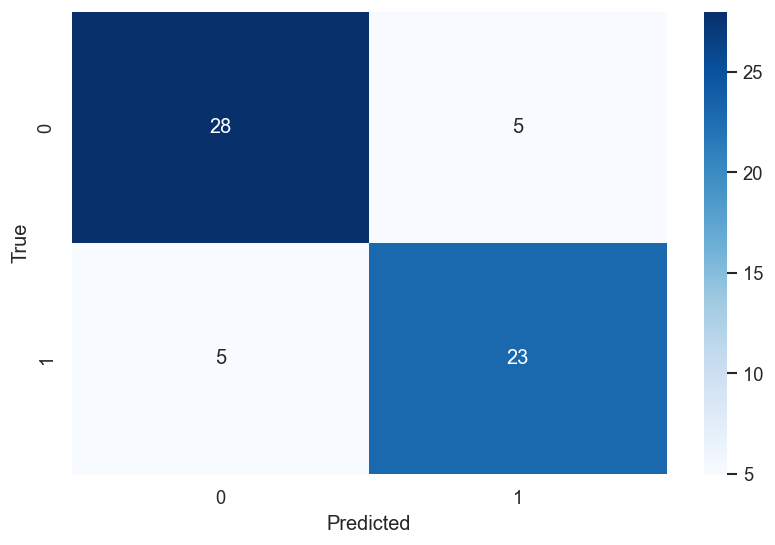

In [16]:
def show_metrics_summary(y_true, y_pred, y_score, title=None):

    print(f"Metrics summary for: {title}\n")
    print("Test roc_auc:", round(roc_auc_score(y_true, y_score),4))

    print(classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.show()

y_pred = svc_best.predict(X_test)
y_pred_proba = svc_best.predict_proba(X_test)
y_score = y_pred_proba[:, pos_idx]

show_metrics_summary(y_bin_test, y_pred, y_score, title=f"best SVC with {svc_grid.best_params_}")


With the GridSearchCV parameters, there is limited/no improvement over the defaults used originally.

My internet/chatGPT research suggested that I should also try optimising the threshold. This is new to me, but I have understood that:
- The threshold is a hyperparameter, and can be tuned to improve performance.
- Threshold changes the classification boundary in score space, not the trained model parameters. C and gamma shape the score distribution; threshold chooses where to cut it.
- The cut-off probability is being calculated by "CalibratedClassifierCV" (see below) and in my implementation is being set to optimise F1 score.


Validation metrics at best threshold:
threshold: 0.4800
accuracy: 0.9180
f1: 0.9123
precision: 0.8966
recall: 0.9286
roc_auc: 0.9665
Metrics summary for: SVC (calibrated) — threshold=0.480

Test roc_auc: 0.9535
              precision    recall  f1-score   support

       False       0.85      0.85      0.85        33
        True       0.82      0.82      0.82        28

    accuracy                           0.84        61
   macro avg       0.83      0.83      0.83        61
weighted avg       0.84      0.84      0.84        61



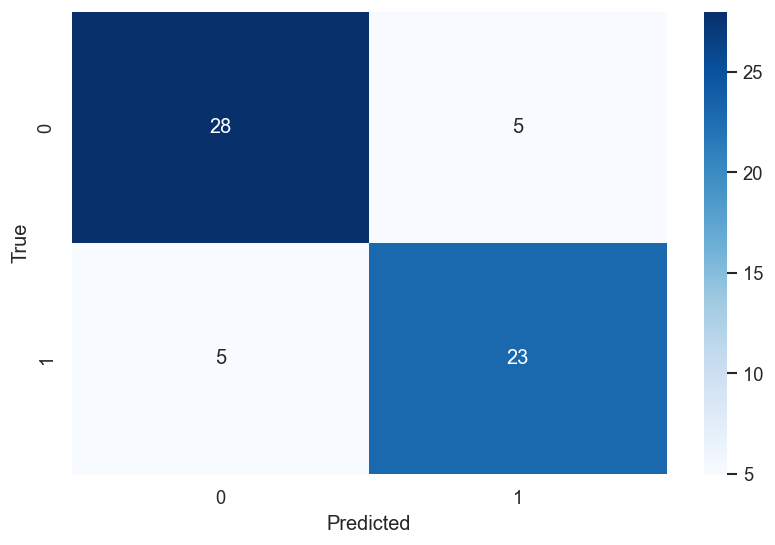

In [17]:
def calibrate_svc_and_select_threshold(
    base_pipeline,
    X_train,
    y_train,
    *,
    valid_size=0.25,
    random_state=42,
    calibration_cv=5,
    calibration_method="sigmoid", # for now assume sigmoid, but could be isotonic or isotonic-regression
    threshold_strategy="f1"  # for now assume "f1", but could also be "youden"
):
    """
    Calibrate an SVC pipeline and select an optimal probability threshold on a validation split.

    Returns:
        calibrated_model: fitted CalibratedClassifierCV wrapping the pipeline
        best_threshold: float in [0,1]
        val_summary: dict with validation metrics at best threshold
    """
    # Split off a validation set from the training data
    X_tr, X_val, y_tr, y_val = train_test_split(
        X_train, y_train, test_size=valid_size, random_state=random_state, stratify=y_train
    )

    # Wrap the pipeline with calibration
    # Note: We pass the entire pipeline as the base_estimator so preprocessing is included.
    calibrated_model = CalibratedClassifierCV(
        estimator=base_pipeline,
        method=calibration_method,
        cv=StratifiedKFold(n_splits=calibration_cv, shuffle=True, random_state=random_state)
    )
    calibrated_model.fit(X_tr, y_tr)

    # Validation probabilities
    y_proba = calibrated_model.predict_proba(X_val)
    y_score = y_proba[:, pos_idx]

    # threshold_strategy is "f1" but could also be "youden" - which would require changing this section of my code
    thresholds = np.linspace(0.0, 1.0, 501)
    scores = []
    for t in thresholds:
        y_pred = (y_score >= t).astype(y_val.dtype)
        scores.append(f1_score(y_val, y_pred))
    best_idx = int(np.nanargmax(scores))

    best_threshold = float(thresholds[best_idx])
    y_val_pred = (y_score >= best_threshold).astype(y_val.dtype)

    val_summary = {
        "threshold": best_threshold,
        "accuracy": accuracy_score(y_val, y_val_pred),
        "f1": f1_score(y_val, y_val_pred),
        "precision": precision_score(y_val, y_val_pred),
        "recall": recall_score(y_val, y_val_pred),
        "roc_auc": roc_auc_score(y_val, y_score),
    }
    return calibrated_model, best_threshold, val_summary

cal_svc, best_thr, val_metrics = calibrate_svc_and_select_threshold(
    base_pipeline=svc_best,
    X_train=X_train,
    y_train=y_bin_train,
    valid_size=0.25,
    random_state=SEED,
    calibration_cv=5,
    calibration_method="sigmoid",
)

print("Validation metrics at best threshold:")
for name, score in val_metrics.items():
    print(f"{name}: {score:.4f}")

# Evaluate on the test set using the chosen threshold
y_test_proba = cal_svc.predict_proba(X_test)
y_test_score = y_test_proba[:, pos_idx]
y_test_pred = (y_test_score >= best_thr).astype(y_bin_test.dtype)

show_metrics_summary(y_bin_test, y_test_pred, y_test_score, title=f"SVC (calibrated) — threshold={best_thr:.3f}")


In [18]:
# Permutation importance on svc_best, if time allows I will find a way to do this for the calibrated model too.
est_for_importance = svc_best

result = permutation_importance(
    est_for_importance, X_test, y_bin_test,
    n_repeats=20, random_state=SEED, scoring="f1"  # or "roc_auc" for ranking-based importance
)

# 1) Names after preprocessor
prep = est_for_importance.named_steps["prep"]
feat_names_pre = prep.get_feature_names_out()

# 2) If there is a selector step, map through it
feat_names = feat_names_pre
selector = None

# Common selector step names you might be using; adjust if yours differs
for step_name in ("sel", "selector", "feature_selector", "var_thresh", "kbest", "pca"):
    if step_name in est_for_importance.named_steps:
        selector = est_for_importance.named_steps[step_name]
        break

if selector is not None:
    if hasattr(selector, "get_support"):
        mask = selector.get_support()
        # Defensive: ensure mask length matches preprocessed features
        if len(mask) == len(feat_names_pre):
            feat_names = np.array(feat_names_pre)[mask]
        else:
            # Fallback if something is off: keep lengths aligned with importances
            feat_names = np.array(feat_names_pre)[: len(result.importances_mean)]
    elif hasattr(selector, "get_feature_names_out"):
        feat_names = selector.get_feature_names_out(input_features=feat_names_pre)
    else:
        # Last-resort fallback: generate generic names of the right length
        feat_names = np.array([f"f{i}" for i in range(len(result.importances_mean))])
else:
    # No selector: still guard in case shapes differ due to other transforms
    if len(feat_names_pre) != len(result.importances_mean):
        feat_names = np.array(feat_names_pre)[: len(result.importances_mean)]
    else:
        feat_names = feat_names_pre

# 3) Build the aligned DataFrame
imp = pd.DataFrame({
    "feature": feat_names,
    "mean_importance": result.importances_mean,
    "std": result.importances_std
}).sort_values("mean_importance", ascending=False)

print(imp.head(20))


# Optional: aggregate one-hot levels back to their source feature
agg = (
    imp.assign(group=imp["feature"].str.replace(r"^(num|cat)__", "", regex=True).str.split("_").str[0])
       .groupby("group", as_index=False)["mean_importance"].sum()
       .sort_values("mean_importance", ascending=False)
)
print("\nAggregated importance by original feature:")
print(agg.head(15))

                    feature  mean_importance       std
12            cat__fbs_True         0.070154  0.037183
11           cat__fbs_False         0.055594  0.030143
2                 num__chol         0.037245  0.029590
1             num__trestbps         0.016739  0.029466
10   cat__cp_typical angina         0.014869  0.015364
8   cat__cp_atypical angina         0.010277  0.025559
9       cat__cp_non-anginal         0.005282  0.021715
5           cat__sex_Female         0.000000  0.000000
0                  num__age        -0.000747  0.003255
4              num__oldpeak        -0.002240  0.005333
7      cat__cp_asymptomatic        -0.005821  0.026709
6             cat__sex_Male        -0.006721  0.007430
3               num__thalch        -0.015609  0.017601

Aggregated importance by original feature:
      group  mean_importance
3       fbs         0.125748
1      chol         0.037245
2        cp         0.024606
7  trestbps         0.016739
0       age        -0.000747
4   oldpeak 

The calibrateed model has a slighly higher AUC score at 0.95 vs 0.94 for the uncalibrated model, otherwise almost identical.

### Model Optimisation and Evaluation - Linear Regression (also for multi-class)
1. Use GridSearchCV to tune SVC-rbf parameters (C and gamma)
2. Use SVC threshold calibration to optimise F1 score
4. Evaluate on test with ROC/PR, confusion matrix, classification report

In [19]:
# Set up a new pipeline for regression with one-hot encoding drop='first' and a selector to limit the features used in the model

# Define preprocessing steps
# num_sel and cat_sel are defined above as:
# num_sel = make_column_selector(dtype_include=["number"])
# cat_sel = make_column_selector(dtype_include=["object", "category", "bool"])

preprocess_reg = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_sel),
        ("cat", OneHotEncoder(handle_unknown="ignore", drop='first', sparse_output=False), cat_sel),
    ],
    remainder="drop"
)

pipe_reg = Pipeline(steps=[
    ("prep", preprocess_reg),
    ("kbest", SelectKBest(score_func=f_regression, k=10)),
    ("reg", LinearRegression())
])

# Tune number of features to use in the model
param_grid = {"kbest__k": [6,8,10,12,14,16,18,"all"]}
gs = GridSearchCV(pipe_reg, param_grid=param_grid, cv=5, scoring="r2", n_jobs=-1)
gs.fit(X_train, y_reg_train)
print("Best k:", gs.best_params_["kbest__k"], "CV R2:", gs.best_score_)
print("Test R2:", gs.best_estimator_.score(X_test, y_reg_test))

pipe_reg_best = gs.best_estimator_

# Create a data frame with the selected features (1) to check output, (2) for later use in Statsmodels
prep = pipe_reg_best.named_steps["prep"]
kbest = pipe_reg_best.named_steps["kbest"]

# 1) Fit/transform the preprocessor on X_train
prep.fit(X_train)
Xt_prep = prep.transform(X_train)
prep_feature_names = prep.get_feature_names_out()

# 2) Fit/transform the selector on the preprocessed matrix
kbest.fit(Xt_prep, y_reg_train)
Xt_kbest = kbest.transform(Xt_prep)
# Determine which features were selected
mask = kbest.get_support()
selected_feature_names = np.array(prep_feature_names)[mask]

# 3) Wrap into a DataFrame to inspect
Xt_kbest_df = pd.DataFrame(Xt_kbest, columns=selected_feature_names, index=X_train.index)
display(Xt_kbest_df.head())
print("After SelectKBest shape:", Xt_kbest_df.shape)
print("Selected features:", list(selected_feature_names))

Best k: all CV R2: 0.461087254136393
Test R2: 0.5938347741147221


,num__age,num__trestbps,num__chol,num__thalch,num__oldpeak,cat__sex_Male,cat__cp_atypical angina,cat__cp_non-anginal,cat__cp_typical angina,cat__fbs_True,cat__restecg_normal,cat__restecg_st-t abnormality,cat__exang_True,cat__slope_flat,cat__slope_upsloping,cat__ca_1.0,cat__ca_2.0,cat__ca_3.0,cat__thal_normal,cat__thal_reversable defect
97,0.594945,1.020911,0.169014,0.307680,1.320132,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
82,-1.711319,0.463338,1.327117,1.411752,-0.900796,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
167,-0.063987,0.017280,0.720492,0.396006,-0.900796,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
288,0.155657,-0.094234,-0.511143,0.572657,-0.900796,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
71,1.363700,-0.373021,0.095483,0.572657,-0.729955,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0


After SelectKBest shape: (242, 20)
Selected features: ['num__age', 'num__trestbps', 'num__chol', 'num__thalch', 'num__oldpeak', 'cat__sex_Male', 'cat__cp_atypical angina', 'cat__cp_non-anginal', 'cat__cp_typical angina', 'cat__fbs_True', 'cat__restecg_normal', 'cat__restecg_st-t abnormality', 'cat__exang_True', 'cat__slope_flat', 'cat__slope_upsloping', 'cat__ca_1.0', 'cat__ca_2.0', 'cat__ca_3.0', 'cat__thal_normal', 'cat__thal_reversable defect']


Found selector step 'kbest' in pipeline


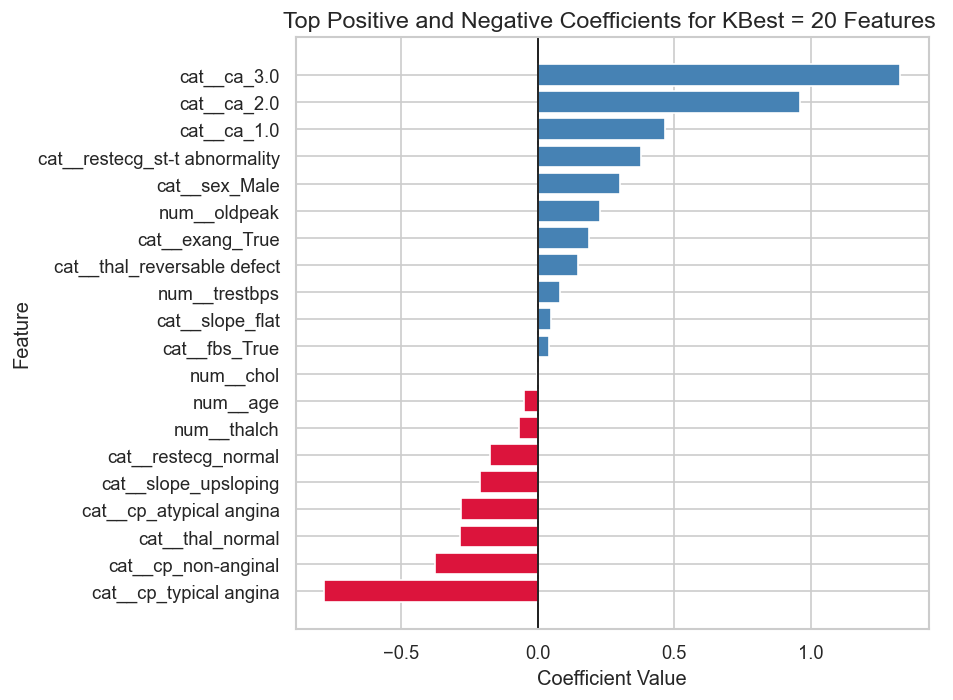

In [20]:
def get_linear_coefs_from_pipeline(pipeline, prep_name="prep", select_name="select", reg_name="reg"):
    """
    Returns a pandas Series mapping feature names to linear coefficients from a Pipeline.
    Supports an optional feature selection step named `select` (e.g., SelectKBest) - added to cope with enhancing LinearRegression
    """

    # 1) Locate preprocessing step to derive transformed feature names
    prep = pipeline.named_steps[prep_name]
    feat_names = np.array(prep.get_feature_names_out(), dtype=str)

    # 2) If a selector exists, reduce feature names using its support mask
    support_mask = None
    selector = None
    if select_name in pipeline.named_steps:
        print(f"Found selector step '{select_name}' in pipeline")
        selector = pipeline.named_steps[select_name]
        support_mask = selector.get_support()
        feat_names = feat_names[support_mask]

    # 3) get coefficients from the final estimator
    est = None
    if reg_name in pipeline.named_steps:
        est = pipeline.named_steps[reg_name]
    if est is None or not hasattr(est, "coef_"):
        raise ValueError("Could not locate a linear estimator with coef_ in the pipeline.")

    coefs = np.asarray(est.coef_)
    coefficients = pd.Series(coefs, index=feat_names)

    return coefficients

linear_coefficients = get_linear_coefs_from_pipeline(pipe_reg_best, select_name="kbest", reg_name="reg")

top_pos = linear_coefficients[linear_coefficients > 0]
top_neg = linear_coefficients[linear_coefficients < 0]

# Combine and sort for nicer barh order
subset = pd.concat([top_pos, top_neg]).sort_values()

# Colors by sign
colors = ["crimson" if v < 0 else "steelblue" for v in subset.values]

plt.figure(figsize=(8, 6))
plt.barh(subset.index.astype(str), subset.values, color=colors)
plt.axvline(0, color="black", linewidth=1)
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.title(f"Top Positive and Negative Coefficients for KBest = {len(linear_coefficients)} Features ")
plt.tight_layout()
plt.show()

#show_regression_metrics_summary(estimator=pipe_kbest12, y_true=y_reg_test, title="Linear Regression")

Optimized thresholds (t0 < t1 < t2 < t3): [1.0509, 1.7104, 1.7829, 2.3491]
Validation — Accuracy: 0.7377 
Macro-F1: 0.5557

Test — Regression metrics on numeric y (for reference)
RMSE: 0.6316 MAE: 0.6149 R2: 0.5938

 -------------------------------------------------------------------------------- 

Test — Ordinal classification metrics via thresholds
Accuracy: 0.6066 Macro-F1: 0.3803

Test classification report:
              precision    recall  f1-score   support

           0      0.811     0.909     0.857        33
           1      0.286     0.182     0.222        11
           2      0.500     0.143     0.222         7
           3      0.375     0.429     0.400         7
           4      0.143     0.333     0.200         3

    accuracy                          0.607        61
   macro avg      0.423     0.399     0.380        61
weighted avg      0.598     0.607     0.585        61



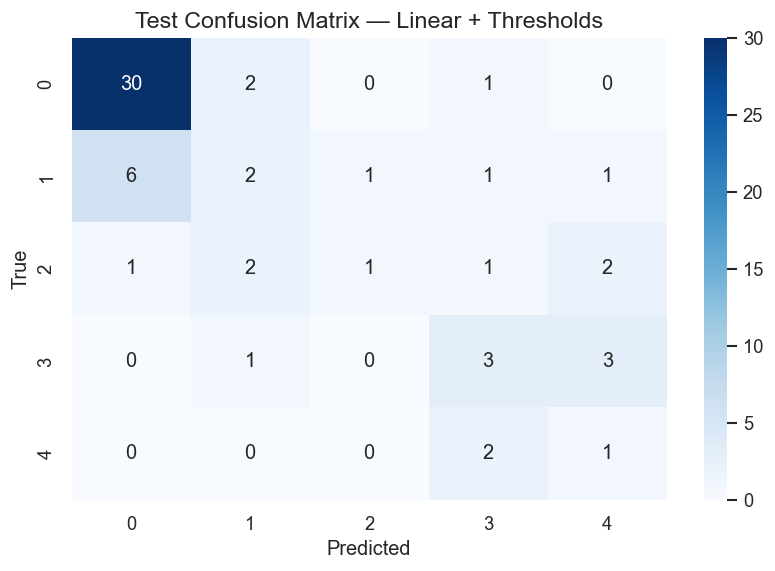

In [21]:
### Linear Regression to Ordinal Classes via Thresholds - using selected model linreg
def predict_classes_from_thresholds(y_hat, thresholds):
    """
    Map continuous predictions to ordinal classes using ascending thresholds.
    thresholds: list/array of length (n_classes - 1)
    """
    thresholds = np.asarray(thresholds, dtype=float)
    return np.digitize(y_hat, thresholds, right=False)  # bins define 0..n_classes-1

def macro_f1(y_true, y_pred):
    return f1_score(y_true, y_pred, average="macro")

def optimize_thresholds_coordinate_descent(y_true, y_hat, n_classes=5, metric="macro_f1", max_iter=10):
    """
    Coordinate-descent threshold optimization with monotonicity constraints.
    - Initializes thresholds from class-conditional means (or percentiles as fallback).
    - Iteratively optimizes each boundary over a set of candidate cut points.
    Returns: thresholds (ascending list of length n_classes-1), history
    """
    assert n_classes >= 2
    y_true = np.asarray(y_true)
    y_hat = np.asarray(y_hat, dtype=float)

    # Candidate cut points between sorted unique predictions
    yh = np.sort(np.unique(y_hat))
    mids = (yh[:-1] + yh[1:]) / 2.0
    if len(mids) == 0:
        # Degenerate case: all predictions equal
        return [float(yh[0])] * (n_classes - 1), []

    # Initialize thresholds using class means (fallback to quantiles if needed)
    init = []
    try:
        class_means = [np.median(y_hat[y_true == c]) for c in range(n_classes)]
        class_means = np.array(class_means, dtype=float)
        # Monotone means; midpoints between adjacent means
        for c in range(n_classes - 1):
            init.append((class_means[c] + class_means[c + 1]) / 2.0)
    except Exception:
        qs = np.linspace(0, 1, n_classes + 1)
        qvals = np.quantile(y_hat, qs)
        init = [float((qvals[i] + qvals[i + 1]) / 2.0) for i in range(1, n_classes)]

    # Ensure sorted and within [min(mids), max(mids)]
    lo, hi = mids.min(), mids.max()
    thr = np.clip(np.sort(np.asarray(init[:-1] + [init[-1]])), lo, hi)

    def eval_metric(thresholds):
        y_pred = predict_classes_from_thresholds(y_hat, thresholds)
        if metric == "accuracy":
            return accuracy_score(y_true, y_pred)
        return macro_f1(y_true, y_pred)

    history = []
    best_score = eval_metric(thr)
    history.append(("init", best_score, thr.copy()))

    for it in range(max_iter):
        improved = False
        for k in range(n_classes - 1):
            # Define allowed region for threshold k based on neighbors
            left_bound = lo if k == 0 else thr[k - 1] + 1e-8
            right_bound = hi if k == (n_classes - 2) else thr[k + 1] - 1e-8

            # Candidates within bounds
            cand = mids[(mids >= left_bound) & (mids <= right_bound)]
            if cand.size == 0:
                continue

            # Scan candidates and pick best
            local_best_score, local_best_t = -np.inf, thr[k]
            for t in cand:
                thr_try = thr.copy()
                thr_try[k] = t
                s = eval_metric(thr_try)
                if s > local_best_score:
                    local_best_score, local_best_t = s, t

            if local_best_score > best_score + 1e-12:
                thr[k] = local_best_t
                best_score = local_best_score
                improved = True
                history.append((f"iter{it}-k{k}", best_score, thr.copy()))

        if not improved:
            break

    return thr.tolist(), history

def show_regression_metrics_summary(estimator=pipe_reg_best, y_true=y_reg_test, title=None):
    # 1) Split off a validation subset from the training data to learn thresholds
    X_tr, X_val, y_tr, y_val = train_test_split(
        X_train, y_reg_train, test_size=0.25, random_state=SEED, stratify=y_reg_train
    )

    estimator.fit(X_tr, y_tr)
    y_val_hat = linreg.predict(X_val)

    # 2) Optimize thresholds on the validation set to maximize macro-F1
    thr_opt, hist = optimize_thresholds_coordinate_descent(
        y_true=y_val, y_hat=y_val_hat, n_classes=5, metric="macro_f1", max_iter=10
    )
    print("Optimized thresholds (t0 < t1 < t2 < t3):", [round(t, 4) for t in thr_opt])

    # 3) Evaluate on validation
    y_val_pred_cls = predict_classes_from_thresholds(y_val_hat, thr_opt)
    print("Validation — Accuracy:", round(accuracy_score(y_val, y_val_pred_cls), 4),
          "\nMacro-F1:", round(f1_score(y_val, y_val_pred_cls, average="macro"), 4))

    # 4) Final fit on full training set and evaluate on test
    estimator.fit(X_train, y_reg_train)
    y_test_hat = estimator.predict(X_test)
    y_test_pred_cls = predict_classes_from_thresholds(y_test_hat, thr_opt)

    print("\nTest — Regression metrics on numeric y (for reference)")
    print("RMSE:", round(mean_squared_error(y_true, y_test_hat), 4),
          "MAE:", round(mean_absolute_error(y_true, y_test_hat), 4),
          "R2:", round(r2_score(y_true, y_test_hat), 4))
    section_split(width=80)
    print("Test — Ordinal classification metrics via thresholds")
    print("Accuracy:", round(accuracy_score(y_true, y_test_pred_cls), 4),
          "Macro-F1:", round(f1_score(y_true, y_test_pred_cls, average='macro'), 4))
    print("\nTest classification report:")
    print(classification_report(y_true, y_test_pred_cls, zero_division=0, digits=3))
    sns.heatmap(confusion_matrix(y_true, y_test_pred_cls), annot=True, fmt="d", cmap="Blues")
    plt.title("Test Confusion Matrix — Linear + Thresholds")
    plt.xlabel("Predicted");
    plt.ylabel("True");
    plt.show()

show_regression_metrics_summary(estimator=pipe_reg_best, y_true=y_reg_test, title="Linear Regression")

## Interpretation
- Coefficients (for linear models)
- Feature importance (tree-based)
- Optional: partial dependence or permutation importance

In [22]:
def ols_summary_and_pvalues_from_pipeline(pipeline, X, y, prep_name="prep", selector_name="kbest"):
    """
    Fit statsmodels OLS on the transformed+selected design matrix from a scikit-learn Pipeline.
    """
    # 1) Transform X using the preprocessing step
    prep = pipeline.named_steps[prep_name]
    X_trans = prep.transform(X)
    all_feat_names = np.array(prep.get_feature_names_out(), dtype=str)

    # 2) Apply the selector to reduce to the chosen features
    selector = pipeline.named_steps[selector_name]
    support = selector.get_support()
    X_sel = selector.transform(X_trans)
    sel_feat_names = all_feat_names[support]

    # 3) Fit OLS in statsmodels on the selected features (+ intercept)
    X_sm = sm.add_constant(X_sel, has_constant="add")
    y_vec = np.asarray(y, dtype=float)
    model_sm = sm.OLS(y_vec, X_sm).fit()

    # 4) Build p-values Series aligned with names
    pvals = pd.Series(model_sm.pvalues, index=["const"] + sel_feat_names.tolist())
    print(model_sm.summary())
    return model_sm, pvals

_ = pipe_reg_best.fit(X_train, y_reg_train)  # ensure fitted
model_sm, pvals = ols_summary_and_pvalues_from_pipeline(pipe_reg_best, X_train, y_reg_train)
print("\nP-values for selected features:")
print(round(pvals.sort_values(),4))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.577
Model:                            OLS   Adj. R-squared:                  0.539
Method:                 Least Squares   F-statistic:                     15.08
Date:                Mon, 15 Sep 2025   Prob (F-statistic):           3.72e-31
Time:                        10:59:27   Log-Likelihood:                -287.60
No. Observations:                 242   AIC:                             617.2
Df Residuals:                     221   BIC:                             690.5
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8355      0.346      2.417      0.0

## Conclusions and Next Steps
- Summary of findings
- What worked best and why
- Ideas for future improvements (feature engineering, calibration, fairness checks, external validation)

## Appendix
- Full parameter settings
- Utility functions
- Links to dataset and documentation

Style and usability tips:
- Use JupyterLab’s Table of Contents (View > Table of Contents) to keep sections navigable.
- Keep figures consistent by setting seaborn theme and matplotlib rcParams.
- Save key figures to a `figs` folder for reuse in reports.
- Limit long prints; prefer concise tables/plots.

Significant features (7): ['num__oldpeak', 'cat__sex_Male', 'cat__cp_non-anginal', 'cat__cp_typical angina', 'cat__ca_1.0', 'cat__ca_2.0', 'cat__ca_3.0']
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.495
Model:                            OLS   Adj. R-squared:                  0.480
Method:                 Least Squares   F-statistic:                     32.76
Date:                Mon, 15 Sep 2025   Prob (F-statistic):           1.59e-31
Time:                        10:59:27   Log-Likelihood:                -309.10
No. Observations:                 242   AIC:                             634.2
Df Residuals:                     234   BIC:                             662.1
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|  

const                     0.443637
num__oldpeak              0.455924
cat__sex_Male             0.458649
cat__cp_non-anginal      -0.415565
cat__cp_typical angina   -0.852901
cat__ca_1.0               0.587270
cat__ca_2.0               1.054034
cat__ca_3.0               1.543019
dtype: float64


Classification accuracy from regression (rounded, clipped to [0,4]): 0.4754

Classification report (rounded regression -> classes):
              precision    recall  f1-score   support

         0.0      0.808     0.636     0.712        33
         1.0      0.200     0.364     0.258        11
         2.0      0.182     0.286     0.222         7
         3.0      0.500     0.286     0.364         7
         4.0      0.000     0.000     0.000         3

    accuracy                          0.475        61
   macro avg      0.338     0.314     0.311        61
weighted avg      0.551     0.475     0.499        61



/Users/seancoffey/PycharmProjects/ML_course/.venv-3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/seancoffey/PycharmProjects/ML_course/.venv-3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/seancoffey/PycharmProjects/ML_course/.venv-3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 

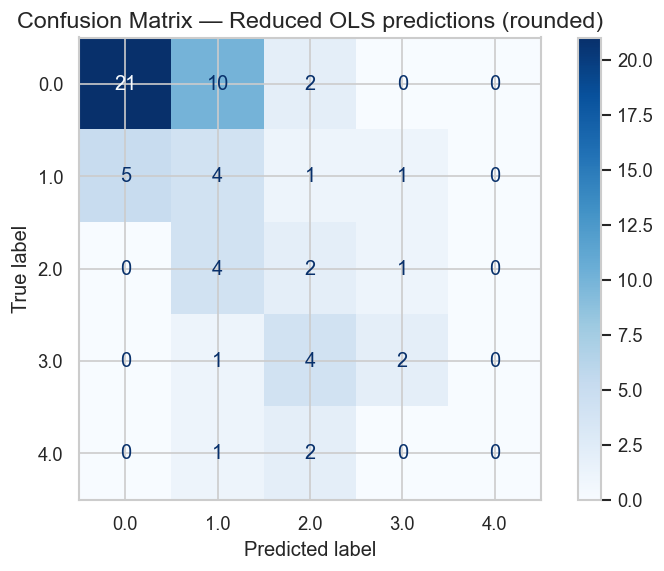

In [23]:
### Statsmodels OLS with only significant (alpha=0.05) coefficients
alpha = 0.05

# 1) Identify significant features from the prior OLS (exclude intercept)
sig_feat = pvals.drop(index="const").loc[lambda s: s < alpha].index.tolist()

if len(sig_feat) == 0:
    print(f"No features are significant at alpha={alpha}.")
else:
    print(f"Significant features ({len(sig_feat)}):", sig_feat)

    # 2) Build train/test matrices for only the significant features
    prep = pipe_reg_best.named_steps["prep"]
    selector = pipe_reg_best.named_steps["kbest"]

    # Ensure preprocessors are fitted (they should be, but this is safe)
    prep.fit(X_train)
    Xtr_prep = prep.transform(X_train)
    Xte_prep = prep.transform(X_test)
    all_feat_names = np.array(prep.get_feature_names_out(), dtype=str)

    # Apply KBest selection as in the pipeline
    selector.fit(Xtr_prep, y_reg_train)
    Xtr_sel = selector.transform(Xtr_prep)
    Xte_sel = selector.transform(Xte_prep)
    sel_feat_names = all_feat_names[selector.get_support()]

    # Map significant names to column indices in the selected matrix
    name_to_pos = {n: i for i, n in enumerate(sel_feat_names)}
    sig_pos = [name_to_pos[n] for n in sig_feat if n in name_to_pos]

    if len(sig_pos) == 0:
        print("None of the significant features remain after selection. Cannot refit reduced OLS.")
    else:
        # 3) Fit reduced OLS on significant features
        Xtr_sig = Xtr_sel[:, sig_pos]
        Xte_sig = Xte_sel[:, sig_pos]

        Xtr_sm = sm.add_constant(Xtr_sig, has_constant="add")
        Xte_sm = sm.add_constant(Xte_sig, has_constant="add")

        ytr = np.asarray(y_reg_train, dtype=float)
        yte = np.asarray(y_reg_test, dtype=float)

        model_sm_sig = sm.OLS(ytr, Xtr_sm).fit()
        print(model_sm_sig.summary())

        # 4) Predict on test set and show summary results
        yte_pred = model_sm_sig.predict(Xte_sm)

        rmse = mean_squared_error(yte, yte_pred)
        mae = mean_absolute_error(yte, yte_pred)
        r2 = r2_score(yte, yte_pred)

        print("\nTest set evaluation (reduced OLS, significant features only):")
        print(f"RMSE: {rmse:.4f} | MAE: {mae:.4f} | R2: {r2:.4f}")

        # (1) Feature names aligned with reduced model columns (const + significant features)
        reduced_feature_names = ["const"] + [sel_feat_names[i] for i in sig_pos]
        print("\nReduced model feature names (in coefficient order):")
        print(reduced_feature_names)

        # Also show name->coef mapping for convenience
        coef_series = pd.Series(model_sm_sig.params, index=reduced_feature_names)
        print("\nCoefficients (const first):")
        display(coef_series)

        # (2) Convert regression outputs to ordinal class predictions via round+clip
        #    Valid classes are based on the observed range in yte (typically 0..4)
        valid_min = int(np.min(yte))
        valid_max = int(np.max(yte))
        yte_pred_cls = np.rint(yte_pred).astype(int)
        yte_pred_cls = np.clip(yte_pred_cls, valid_min, valid_max)

        # Quick accuracy of these class predictions
        acc_cls = accuracy_score(yte, yte_pred_cls)
        print(f"\nClassification accuracy from regression (rounded, clipped to [{valid_min},{valid_max}]): {acc_cls:.4f}")

        # (3) Confusion matrix + report
        from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

        cm = confusion_matrix(yte, yte_pred_cls, labels=sorted(np.unique(yte)))
        print("\nClassification report (rounded regression -> classes):")
        print(classification_report(yte, yte_pred_cls, digits=3))

        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(np.unique(yte)))
        disp.plot(cmap="Blues", values_format="d")
        plt.title("Confusion Matrix — Reduced OLS predictions (rounded)")
        plt.show()
